# Исследование аудитории приложения "Ненужные вещи"

## Материалы

* [Презентация](https://disk.yandex.ru/i/KT0dg_YY9Y3J2w)

## **Цель и задачи исследования**

**Цель исследования** – выделение групп пользователей приложения "Ненужные вещи" на основе их поведения для управления вовлеченностью и адаптации приложения под целевую и смежные аудитории.

**Задачи исследования**: 
* Выделение групп пользователей, отличающихся по уровню удержания (Retention Rate). Определение факторов, влияющих на удержание;
* Выделение групп пользователей, различающихся по времени, проведенному в приложении. Определение характеристик пользователей, которые проводят в приложении больше времени;
* Выделение групп пользователей по частоте совершения действий в приложении;
* Выделение групп пользователей по конверсии в целевое действие "просмотр контактов". Определение характеристик группы, пользователи которой часто делают целевое действие. 

**Источники исследования** – датасет `mobile_sources` с информацией об источнике, с которого каждый пользователь установил приложение, и датасет `mobile_dataset` с логами пользователей после 7 октября 2019 года. 

## Подготовка к работе. Выгрузка и знакомство с данными

In [1]:
# импорт необходимых для работы библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
import itertools

In [2]:
# улучшение качества графиков

%config InlineBackend.figure_format = 'retina'

In [3]:
# выгрузка датасетов

try:
    mobile_df = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv', parse_dates=True)
    mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv', parse_dates=True)
except:
    mobile_df = pd.read_csv('/Users/mimikhailova/Downloads/mobile_dataset.csv', parse_dates=True)  
    mobile_sources = pd.read_csv('/Users/mimikhailova/Downloads/mobile_sourсes.csv', parse_dates=True)

In [4]:
# функция для получения общей информации о датасете

def general_info(data):
    try:
        print('Первые пять строк датасета:')
        display(data.head(5))
        print('\nОбщая информация о датасете:\n')
        display(data.info())
        print('\nCтатистические характеристики количественных признаков:')
        display(data.describe().transpose())
        print(f'\nКоличество явных дубликатов: {data.duplicated().sum()}')
        print(f'\nКоличество пропусков:\n{data.isna().sum()}')
        
        pass_values(data)
        
    except:
        print(f'Произошла ошибка в основной функции')
    
def pass_values(data):
    try:
        pass_values = (data.isna().mean()*100).sort_values(ascending=True)
        plt.figure(figsize=(10,5))
        plt.barh(pass_values.index, pass_values, color='#00B7C2', alpha=0.7)
        plt.title('Визуализация пропущенных значений в процентах\n', fontsize=14)
        plt.xlabel('\nПроцент пропусков', fontsize=12)
        plt.ylabel('Столбцы таблицы\n', fontsize=12)
        plt.xlim(0, 100)
        for i, v in enumerate(pass_values):
            plt.text(v, i, f'{v:.2f}%', color='#01204E', va='center')
    except:
        print('Пропусков не осталось, или произошла ошибка в функции pass_values')

Первые пять строк датасета:


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c



Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None


Cтатистические характеристики количественных признаков:


,count,unique,top,freq
event.time,74197,74197,2019-10-11 20:03:30.689517,1
event.name,74197,16,tips_show,40055
user.id,74197,4293,cb36854f-570a-41f4-baa8-36680b396370,478



Количество явных дубликатов: 0

Количество пропусков:
event.time    0
event.name    0
user.id       0
dtype: int64


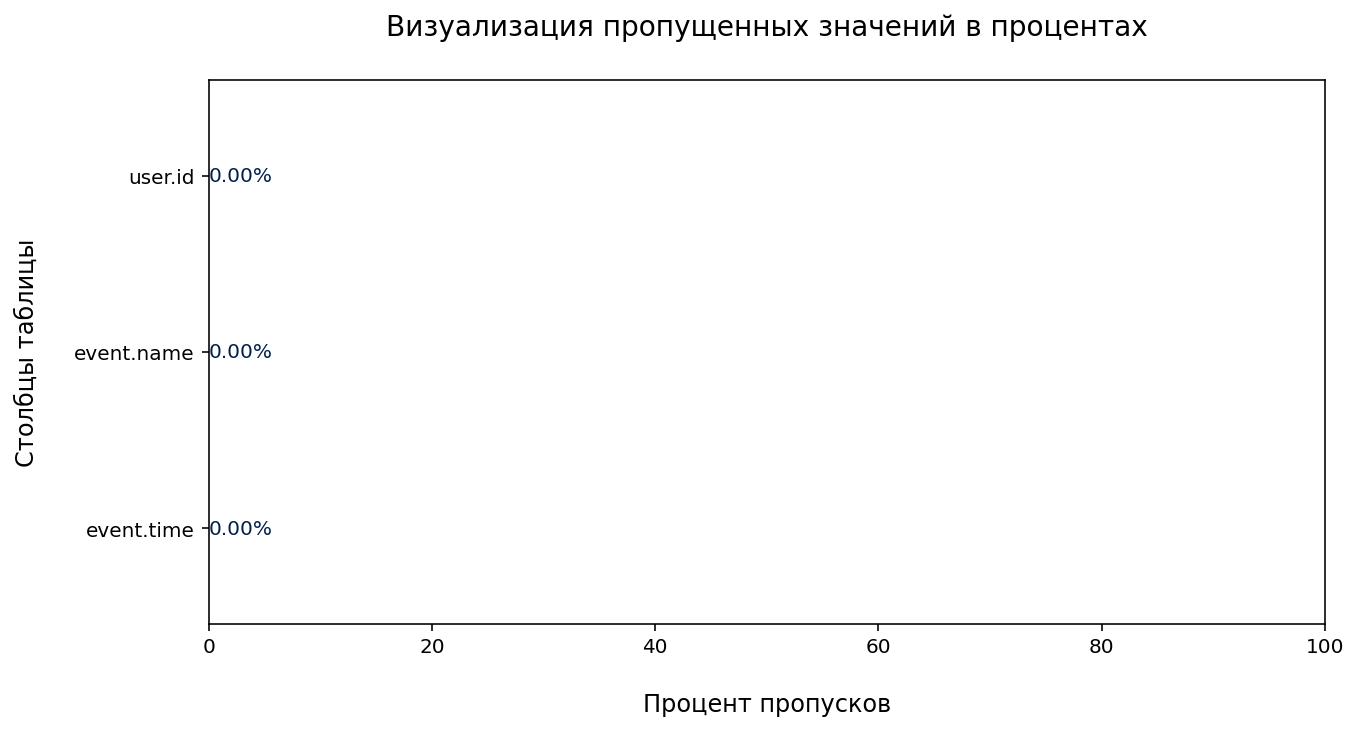

In [5]:
general_info(mobile_df)

Первые пять строк датасета:


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google



Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None


Cтатистические характеристики количественных признаков:


,count,unique,top,freq
userId,4293,4293,571c7fb3-f304-4647-a337-8c16baeccf9b,1
source,4293,3,yandex,1934



Количество явных дубликатов: 0

Количество пропусков:
userId    0
source    0
dtype: int64


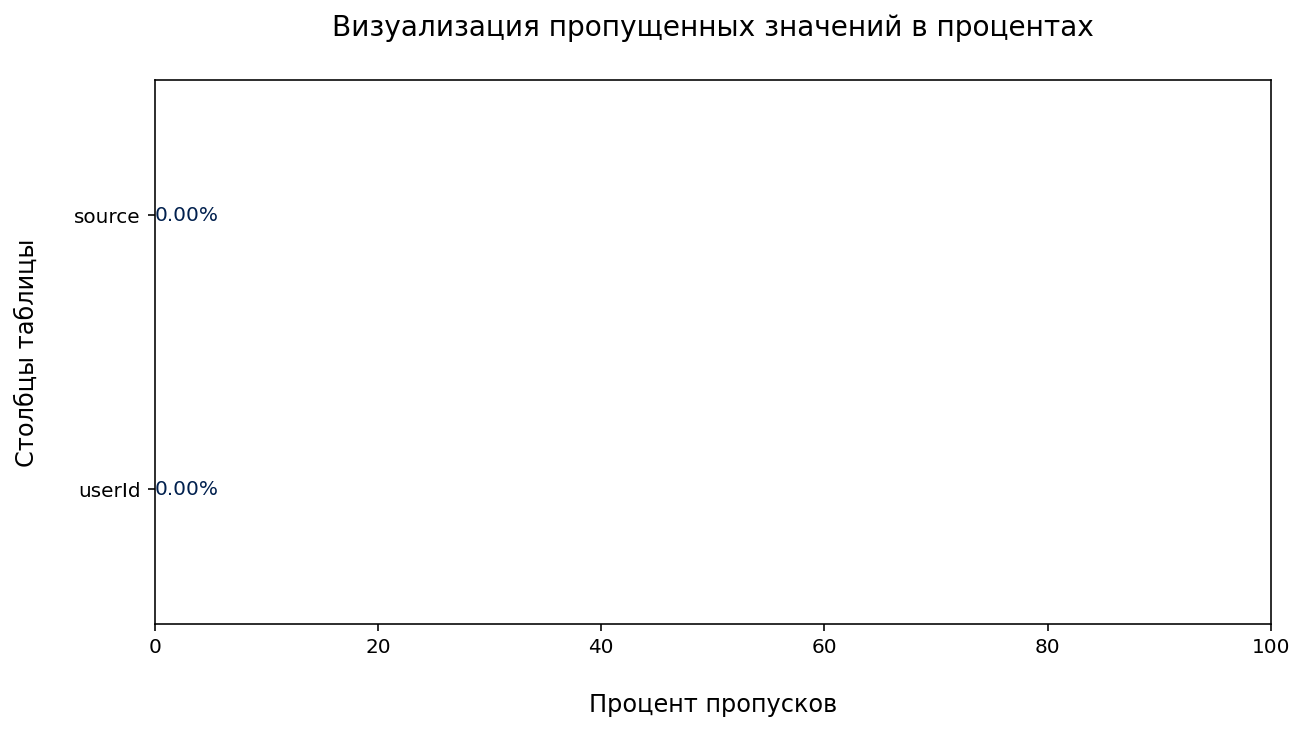

In [6]:
general_info(mobile_sources)

📌 **Выводы по знакомству с данными**

Датасет `mobile_df`:
* Включает 74197 записей о действиях пользователей приложения. Состоит из 3-х полей – время совершения события, название события и идентификатор пользователя, совершившего событие;
* **Названия полей требуют переименования** для удобства выполнения исследования;
* Поле с временем совершения события нуждается в изменении типа данных на **datetime**;
* Пропущенные значения и явные дубликаты в датасете отсутствуют. 

____

Датасет `mobile_sources`:
* Включает 4293 записи об источниках установки приложения. Состоит из 2-х полей – идентификатор пользователя и источник установки приложения. 
* Для удобства выполнения исследования **названия полей нуждаются в переименовании;**
* Пропущенные значения и явные дубликаты в датасете отсутствуют. Необходимости в преобразовании типов данных нет. 

## Предобработка данных

### Переименование столбцов

Для удобства дальнейшего анализа, переименуем названия полей в обоих датасетах, используя "змеиный стиль":

In [7]:
mobile_df.rename(columns={'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'}, inplace=True)
mobile_sources.rename(columns={'userId':'user_id'}, inplace=True)

In [8]:
# проверка

display(mobile_df.columns)
display(mobile_sources.columns)

Index(['event_time', 'event_name', 'user_id'], dtype='object')

Index(['user_id', 'source'], dtype='object')

### Изменение типов данных


#### Столбец `event_time`:

Значения в столбце `event_time` описывают время, в которое было совершено событие, поэтому для дальнейшего анализа их целесообразно перевести в соответствующий формат **datetime**:

In [9]:
# перевод в формат datetime

mobile_df['event_time'] = pd.to_datetime(mobile_df['event_time'])

In [10]:
# проверка

mobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Объединение данных

Объединим данные двух датасетов в единый датасет `mobile_full` по полю `user_id`:

In [11]:
# объединение датасетов

mobile_full = mobile_df.merge(mobile_sources, how='left', on='user_id')

Проверим корректность совершенного объединения, соотнеся размеры всех датасетов:

In [12]:
# размеры исходных и получившегося датасета

display(mobile_df.shape)
display(mobile_sources.shape)
display(mobile_full.shape)

(74197, 3)

(4293, 2)

(74197, 4)

Мы объединяли данные таким образом, чтобы все записи из датасета `mobile_df` сохранились. Поэтому могут возникнуть пропущенные значения в столбце `source`, т.е для каких-то пользователей не будет известен источник установки приложения. Проверим это:

In [13]:
# поиск пропущенных значений

mobile_full.isna().sum()

event_time    0
event_name    0
user_id       0
source        0
dtype: int64

In [14]:
mobile_full.columns

Index(['event_time', 'event_name', 'user_id', 'source'], dtype='object')

### Добавление столбцов

####  Столбец session_id c номером сессии в разрезе каждого пользователя

Для выделения сессий будем брать таймаут в 30 минут, так как:
* Данное значение является общепринятым в индустрии;
* Исследования показывают, что пользователи часто возвращаются к приложению или сайту в течение 30 минут после последнего действия. Это время достаточно для того, чтобы считать, что пользователь все еще активно взаимодействует с контентом.

In [15]:
# сортировка датасета

mobile_full = mobile_full.sort_values(['user_id', 'event_time'])

# Разница во времени между событиями в секундах

diff = mobile_full.groupby('user_id')['event_time'].diff().dt.total_seconds()

# Определение новых сессии (если разница больше 1800 секунд или это первое событие)

new_session = (diff.isnull()) | (diff > 1800)

# Уникальный идентификатор сессии для каждого пользователя 

mobile_full['new_session'] = new_session
mobile_full['session_id'] = mobile_full.groupby('user_id')['new_session'].cumsum()
mobile_full = mobile_full.drop('new_session', axis=1)

In [16]:
mobile_full.head()

,event_time,event_name,user_id,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1


####  Столбец `session_duration` c продолжительностью каждой сессии

In [17]:
# Время начала и конца для каждой сессии

session_durations = mobile_full.groupby(['user_id', 'session_id']).agg(
    session_start=('event_time', 'min'),
    session_end=('event_time', 'max')
).reset_index()

# Столбец с длительностью каждой сессии 

session_durations['session_duration'] = (session_durations['session_end'] - session_durations['session_start'])\
.dt.total_seconds()

# Объединение с датасетом mobile_full

mobile_full = mobile_full.merge(session_durations[['user_id', 'session_id', 'session_duration']], 
                                 on=['user_id', 'session_id'], 
                                 how='left')

In [18]:
mobile_full.head()

,event_time,event_name,user_id,source,session_id,session_duration
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258


#### Столбец `returned`, указывающий на вернувшихся пользователей
* 0 - пользователь не вернулся в приложение (количество сессий =1)
* 1 - пользователь вернулся в приложение (количество сессий >1)

In [19]:
# расчет количества сессий для каждого пользователя 

session_counts = mobile_full.groupby('user_id', as_index=False)\
.agg({'session_id':'nunique'}).rename(columns={'session_id':'session_cnt'})

# добавление столбца returned

session_counts['returned'] = (session_counts['session_cnt'] > 1).astype(int)

# объединение с датасетом mobile_full

mobile_full = mobile_full.merge(session_counts[['user_id', 'returned']], on='user_id', how='left')

In [20]:
mobile_full.head()

,event_time,event_name,user_id,source,session_id,session_duration,returned
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1


#### Столбец `contacts_viewed`, указывающих на действие "просмотр контактов"
* 0 - пользователь не смотрел контакты
* 1 - пользователь смотрел контакты

In [21]:
mobile_full['contacts_viewed'] = mobile_full['event_name']\
.apply(lambda x: 1 if x == 'contacts_show' or x == 'show_contacts' else 0)

In [22]:
mobile_full.head()

,event_time,event_name,user_id,source,session_id,session_duration,returned,contacts_viewed
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1,0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1,0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1,0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1,0


📌 **Результаты предобработки:**
* Названия стобцов были переименованы для удобства дальнейшего исследования;
* В столбце `event_name` был изменен тип данных на datetime;
* Предоставленные датасеты были объединены по идентификатору пользователя;
* В объединенный датасет были добавлены: столбец `session_id` с уникальным номером сессии в разрезе каждого пользователя с учетом тайм-аута в 30 минут, столбец `session_duration` с продолжительностью каждой сессии, столбец `returned`, указывающий на вернувшихся пользователей и столбец `contacts_viewed`, указывающий на совершение действия "просмотр контактов". 

## Исследовательский анализ данных

###  Анализ показателя Retention Rate

#### Создание профилей пользователей

Создадим пользовательские профили, в которых отразим дату первого посещения:

In [23]:
# функция для создания профилей пользователей 

def get_profiles(df):
    profiles = (
        df.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first'})
        .rename(columns={'event_time': 'first_visit'})
        .reset_index() 
    )

    profiles['dt'] = profiles['first_visit'].dt.date

    return profiles

In [24]:
profiles = get_profiles(mobile_full)
profiles.head()

,user_id,first_visit,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,2019-10-25


Имеем 4293 пользовательских профиля с информацией о дате первого посещения приложения. 

#### Формирование таблицы удержания

В датасете представлены логи пользователей в период с `2019-10-07` по `2019-11-03`, то есть за 28 календарных дней. Построим таблицу удержания, в которой отразим:
* дату формирования когорты по дате первого посещению приложения
* долю вернувшихся пользователей для каждой когорты

Для исследования показателя Renetion Rate <u>мобильного приложения</u> примем за **горизонт анализа – 7 дней**. Таким образом, мы будем отслеживать поведение пользователей, которые начали использовать приложение с `2019-10-07` по `2019-10-28`. 

Создадим функцию для расчета Retention Rate:

In [25]:
# Функция для расчета Retention Rate

def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):
    
    # Исключение пользователей, не «доживших» до горизонта анализа
    
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        result = profiles.query('dt <= @last_suitable_acquisition_date')
    else:
        result = profiles

    # Объединение данных обо всех посещениях и полученные профили

    retention_raw = result.merge(sessions[['user_id', 'event_time']], on='user_id', how='left')

    # Расчет лайфтайма в днях 

    retention_raw['lifetime'] = (retention_raw['event_time'] - retention_raw['first_visit']).dt.days

    # Построение таблицы удержания

    retention_table = retention_raw.pivot_table(index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique')

    # Формирование когорт на основе первого дня посещения

    cohort_sizes = (retention_raw.groupby('dt').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))

    # Объединение когорт с таблицей удержания

    retention_table = cohort_sizes.merge(retention_table, on='dt', how='left').fillna(0)

    # Расчет коэффициентов удержания

    retention_table = retention_table.div(retention_table['cohort_size'], axis=0).drop(columns=['cohort_size'])

    # Восстановление столбца с размерами когорт
    retention_table['cohort_size'] = cohort_sizes

    # Исключение лайфтаймов, превышающих горизонт анализа
    retention_table = retention_table[['cohort_size'] + list(range(horizon_days))]

    return retention_raw, retention_table

#### Анализ Renention Rate

In [26]:
retention_raw, retention = get_retention(profiles, mobile_full, datetime(2019, 11, 3).date(), 7)

retention

,cohort_size,0,1,2,3,4,5,6
dt,,,,,,,,
2019-10-07,204,1.0,0.122549,0.098039,0.107843,0.053922,0.039216,0.058824
2019-10-08,167,1.0,0.161677,0.125749,0.053892,0.041916,0.065868,0.053892
2019-10-09,176,1.0,0.073864,0.062500,0.056818,0.068182,0.068182,0.056818
2019-10-10,174,1.0,0.091954,0.103448,0.080460,0.097701,0.080460,0.068966
2019-10-11,136,1.0,0.088235,0.117647,0.095588,0.088235,0.073529,0.073529
2019-10-12,125,1.0,0.128000,0.160000,0.056000,0.064000,0.088000,0.080000
2019-10-13,148,1.0,0.128378,0.067568,0.054054,0.067568,0.054054,0.054054
2019-10-14,185,1.0,0.113514,0.102703,0.102703,0.081081,0.070270,0.054054
2019-10-15,186,1.0,0.139785,0.091398,0.080645,0.053763,0.053763,0.080645


Построим тепловую карту, чтобы сравнить удержание нескольких когорт:

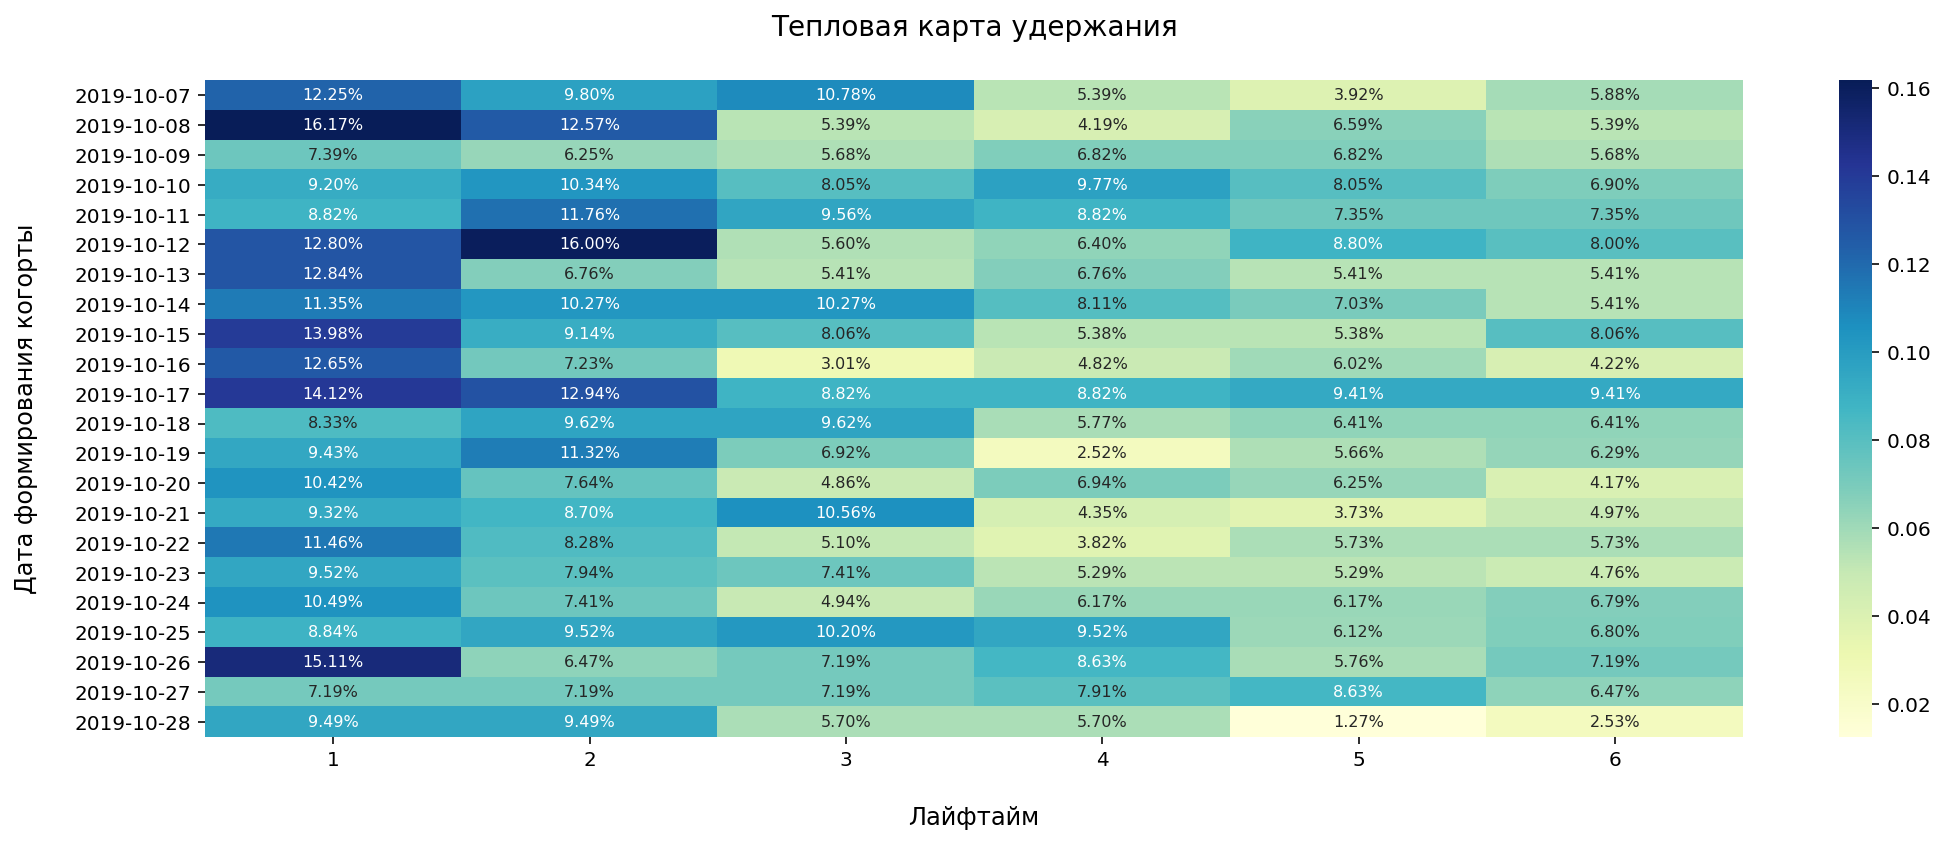

In [27]:
# тепловая карта удержания для всех когорт

plt.figure(figsize=(15, 6)) 
sns.heatmap(retention.drop(columns=['cohort_size', 0]),  annot=True, fmt='.2%', cmap='YlGnBu', annot_kws={"size": 8})
plt.title('Тепловая карта удержания\n', fontsize=14) 
plt.xlabel('\nЛайфтайм', fontsize=12)
plt.ylabel('Дата формирования когорты\n', fontsize=12)
plt.tight_layout()
plt.show()

📌 **Выводы:**
* Уже на второй день использования приложения доля пользователей всех когорт не поднимается **выше 17%**. Это значение может сигнализировать об отсутвии интереса и низкой вовлеченности;
* Топ-5 когорт по наилучшему удержанию на второй день: **2019-10-08** (16.17%), **2019-10-26** (15.11%), **2019-10-17** (14.12%), **2019-10-15** (13.98%), **2019-10-13** (12.84%);
* Топ-3 когорты по наилучшему удержанию на седьмой день: **2019-10-17** (9.41%), **2019-10-15** (8.06%), **2019-10-12** (8.00%);
* Наиболее стабильные когорты с точки зрения динамики удержания пользователей: **2019-10-12**, **2019-10-17**;
* Отметим, что более высокое удержание показывают когорты, образованные **с 2019-10-07 по 2019-10-17**;
* Можно увидеть, что внутри каждой когорты доля вернувшихся пользователей **не уменьшается монотонно с увеличением лайфтайма**. Это явление вполне ожидаемо, поскольку специфика нашего приложения не предполагает ежедневного использования. 

### Анализ времени, проведенного в приложении

Проанализируем **описательные статистики** столбца `session_duration`, чтобы сформировать общее представление о времени, которое пользователи тратят на одну сессию в приложении. Предварительно уберем дубликаты по ключам user_id и session_duration:

In [28]:
# Удаление дубликатов по ключу user_id, чтобы избежать дублирование длительностей сессий

mobile_full_first = mobile_full.drop_duplicates(subset=['user_id', 'session_duration'], keep='first')

In [29]:
mobile_full_first['session_duration'].describe()

count     9395.000000
mean       852.695029
std       1224.241855
min          0.000000
25%         84.906053
50%        425.032919
75%       1155.830206
max      19318.296302
Name: session_duration, dtype: float64

📌 **Выводы:**
* Средняя продолжительность одной сессии составляет ≈**853 секунд/14 минут**, а медианная – ≈**425 секунды/7 минут**. Такое различие сигнализирует о наличии аномально коротких/длинных сессий, а также о том, что половина всех пользователей проводит в приложении около 7 минут; 
* Стандартное отклонение в ≈**1224.08 секунд/20 минут** указывает на то, что продолжительность сессий варьируется значительно. Есть пользователи, которые проводят много времени в приложении, а также те, кто выходит очень быстро;
* Минимальная продолжительность сессии равна **0 секундам**. Такая продолжительность может быть в случае, если пользователь закрыл приложение сразу после открытия, например;
* Максимальная продолжительность сессии равна ≈**19318 секундам/5 часам**. 

Для наглядности построим **гистограмму распределения длительности сессий:**

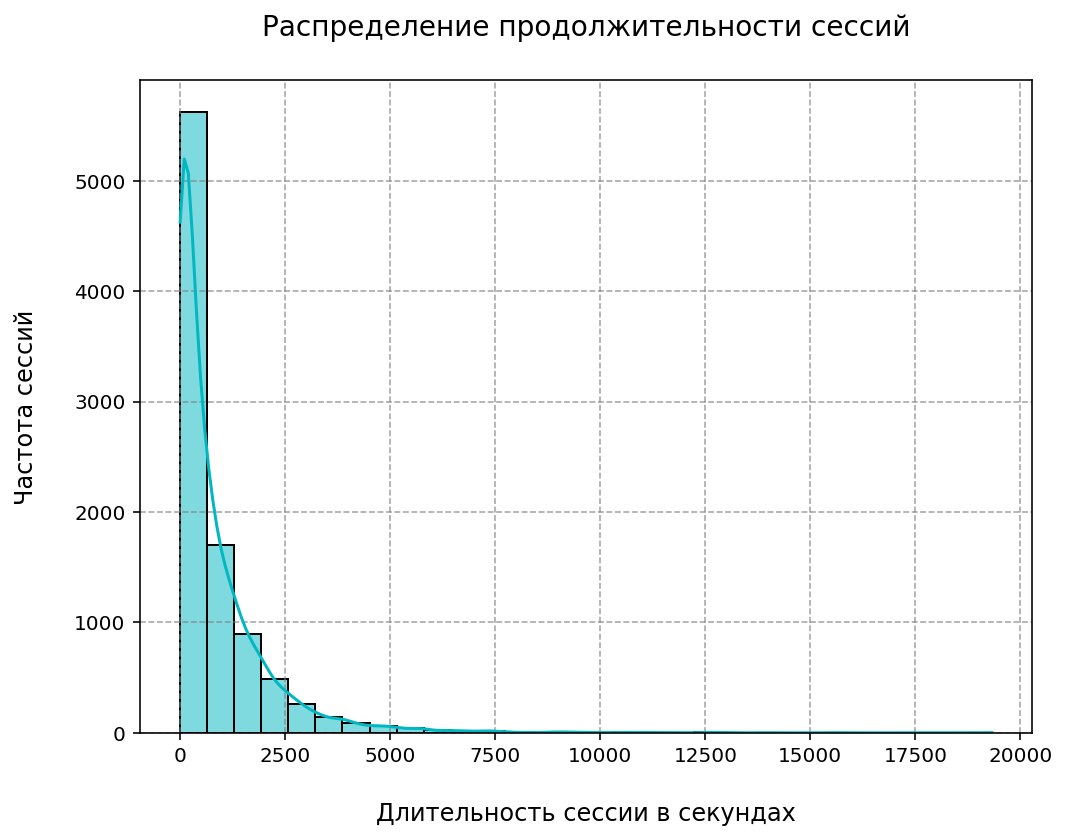

In [30]:
# Гистограмма распределения длительности сессий

plt.figure(figsize=(8, 6))
sns.histplot(mobile_full_first['session_duration'], bins=30, kde=True, color='#00b7c2')
plt.title('Распределение продолжительности сессий\n', fontsize=14)
plt.xlabel('\nДлительность сессии в секундах', fontsize=12)
plt.ylabel('Частота сессий\n', fontsize=12)
plt.grid(linestyle='--', color='gray', alpha=0.7)
plt.show()

📌 **Выводы:**
* Продолжительнсть наибольшего количества сессий не превышает ≈**625 секунд/10 минут**;
* Распределение имеет положительную скошенность. 

**Рассмотрим подробнее сессии, длительность которых равна 0 секундам:**

In [31]:
# датасет с информацией об аномально коротких сессиях

short_sessions = mobile_full_first.query('session_duration == 0')
short_sessions.head()

,event_time,event_name,user_id,source,session_id,session_duration,returned,contacts_viewed
105,2019-11-03 17:12:09.708771,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,6,0.0,1,1
155,2019-10-29 02:17:12.342406,photos_show,00551e79-152e-4441-9cf7-565d7eb04090,yandex,3,0.0,1,0
188,2019-10-20 14:57:06.080501,contacts_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,1,0.0,1,1
237,2019-10-18 15:51:02.186212,contacts_show,00a93a72-3bbc-4ee7-8a81-7134f45ae009,google,3,0.0,1,1
314,2019-10-11 12:20:48.990262,map,013bbb57-ca6f-4af3-b586-4a046d3d3dee,other,1,0.0,1,0


In [32]:
# доля аномально коротких сессий

round(short_sessions.shape[0]*100 / mobile_full_first.shape[0],2)

11.87

In [33]:
# виды действий внутри аномально коротких сессий

short_sessions['event_name'].unique()

array(['contacts_show', 'photos_show', 'map', 'tips_show', 'search_1',
       'search_5', 'favorites_add', 'search_3', 'search_4', 'tips_click',
       'show_contacts', 'search_7', 'advert_open'], dtype=object)

In [34]:
# частота совершенных действий внутри аномально коротких сессий

short_sessions.groupby('event_name').agg({'user_id':'count'}).sort_values('user_id', ascending=False)

,user_id
event_name,
tips_show,481
photos_show,257
search_1,169
map,71
contacts_show,68
advert_open,18
favorites_add,17
search_5,12
tips_click,8


In [35]:
# подсчет количества действий внутри каждой уникальной сессиии

short_sessions.groupby(['session_id', 'user_id']).agg({'event_time':'count'})['event_time'].unique()

array([1])

📌 **Выводы:**
* Сессии с подобной продолжительностью указывают пользователей, которые открыли приложение, но не взаимодействовали с ним или закрыли его сразу после открытия. Это может быть связано с отсутствием интереса, проблемами с загрузкой приложения или неудачными попытками входа;
* Все сессии с продолжительностью в 0 секунд состоят **только из одного действия**;
* Наибольшее количество таких сессий связано с действиями **tips_show** (показ рекомендованного объявления), **photos_show** (показ фото в объявлении) – что вполне естественно для объявлений, которые отображаются на главном экране приложения, например. Высокая частота этих действий в сочетании с нулевой продолжительностью сессий может указывать на **проблемы с удержанием пользователей**. Данные действия также связаны с контентом, который видят пользователи при первом открытии приложения. Стоит подумать в сторону анализа и улучшения этого контента или его представления;
* Для других действий установить "природу" нулевой продолжительности при имеющейся информации будет затруднительно. 

#### Динамика средней продолжительности сессии

Построим график, иллюстрирующий, как меняется средняя продолжительности сессии (в минутах) каждый день в течение данного периода:

In [36]:
# переводим продолжительность сессии в минуты и меняем индекс

mobile_full_first_1 = mobile_full_first.set_index('event_time')
mobile_full_first_1['session_duration'] = mobile_full_first_1['session_duration']/60

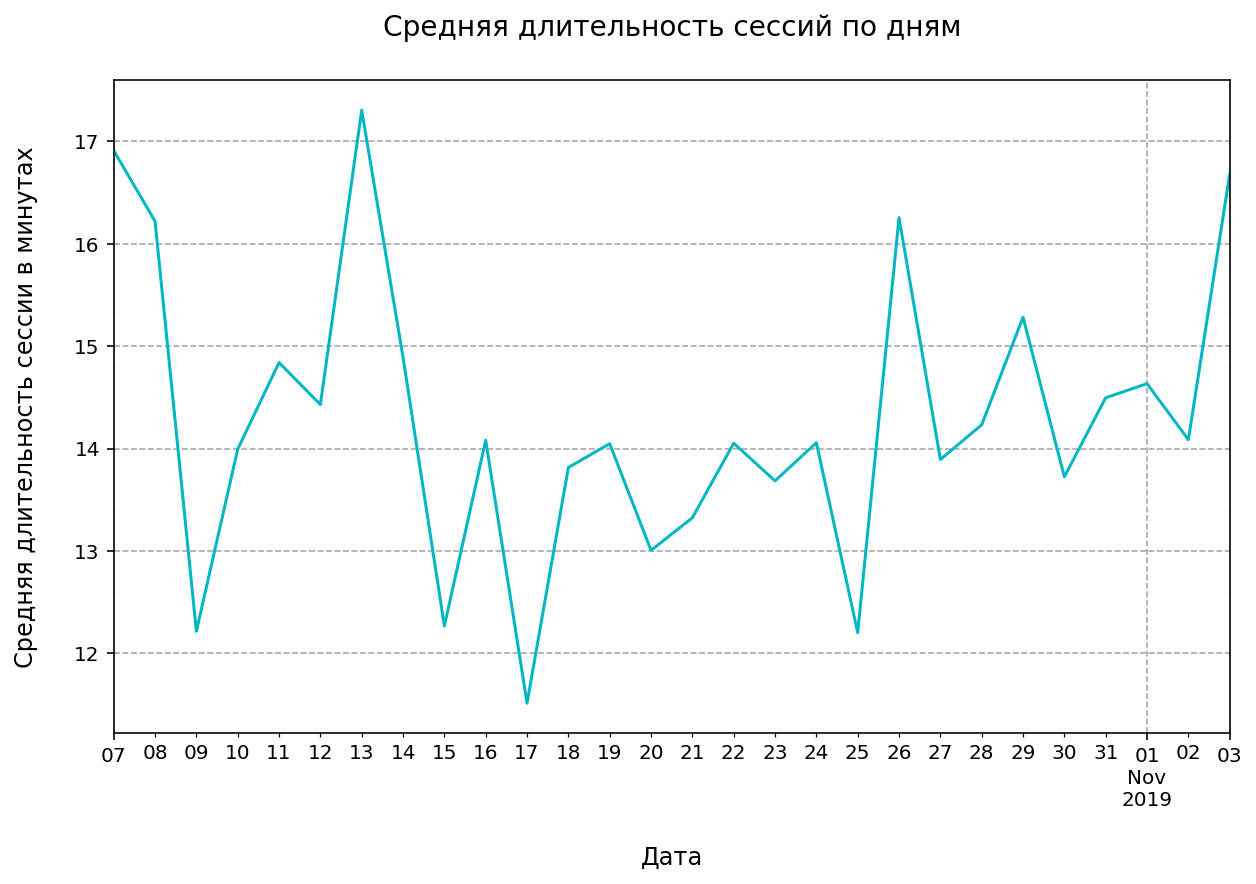

In [37]:
# Группировка по дате и вычисление средней длительности сессии
daily_avg_duration = mobile_full_first_1.resample('D')['session_duration'].mean()

# Построение графика

plt.figure(figsize=(10, 6))
daily_avg_duration.plot(color='#00b7c2')
plt.title('Средняя длительность сессий по дням\n', fontsize=14)
plt.xlabel('\nДата', fontsize=12)
plt.ylabel('Средняя длительность сессии в минутах\n', fontsize=12)
plt.grid(linestyle='--', color='gray', alpha=0.7)
plt.show()

📌 **Выводы:**
* Средняя продолжительность сессии по дням колеблется в диапазоне от **12 до 18 минут**;
* Наибольшее значение средней продолжительности сессии было достигнуто **13 октября** (>17 минут), а наименьшее – **17 октября** (≈11 минут);
* Колебания средней продолжительности сессии день-ото-дня не превышают 5 минут. 

#### Распределение количества сессий по пользователям

Проанализируем количество сессий, приходящийся на одного пользователя приложения:

In [38]:
# сводная таблица с количеством сессий для каждого пользователя

mobile_full_session_cnt = mobile_full.groupby('user_id').agg({'session_id':'nunique'})\
                          .rename(columns={'session_id':'session_cnt'})\
                          .sort_values('session_cnt', ascending = False)

In [39]:
# описательные статистики полученного датасета

mobile_full_session_cnt['session_cnt'].describe()

count    4293.000000
mean        2.415094
std         3.536466
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        99.000000
Name: session_cnt, dtype: float64

📌 **Выводы:**
* Среднее количество сессий на одного пользователя составляет ≈**2**. Медианное количество сессий равно **1**, то есть половина пользователей совершили 1 сессию и не являются активными. Большая часть пользователей не возвращается в приложение после первой сессии, что вновь указывает на **проблемы с удержанием пользователей**;
* Стандартное отклонение составляет ≈3.54, что указывает на то, что значения могут значительно варьироваться. Все же есть пользователи, которые активно используют приложение, но также немало и тех тех, кто использует его только один раз;
* Заметим также, что 75% пользователей совершили не более 3 сессий в приложении, что также подтверждает **низкую вовлеченность.** 

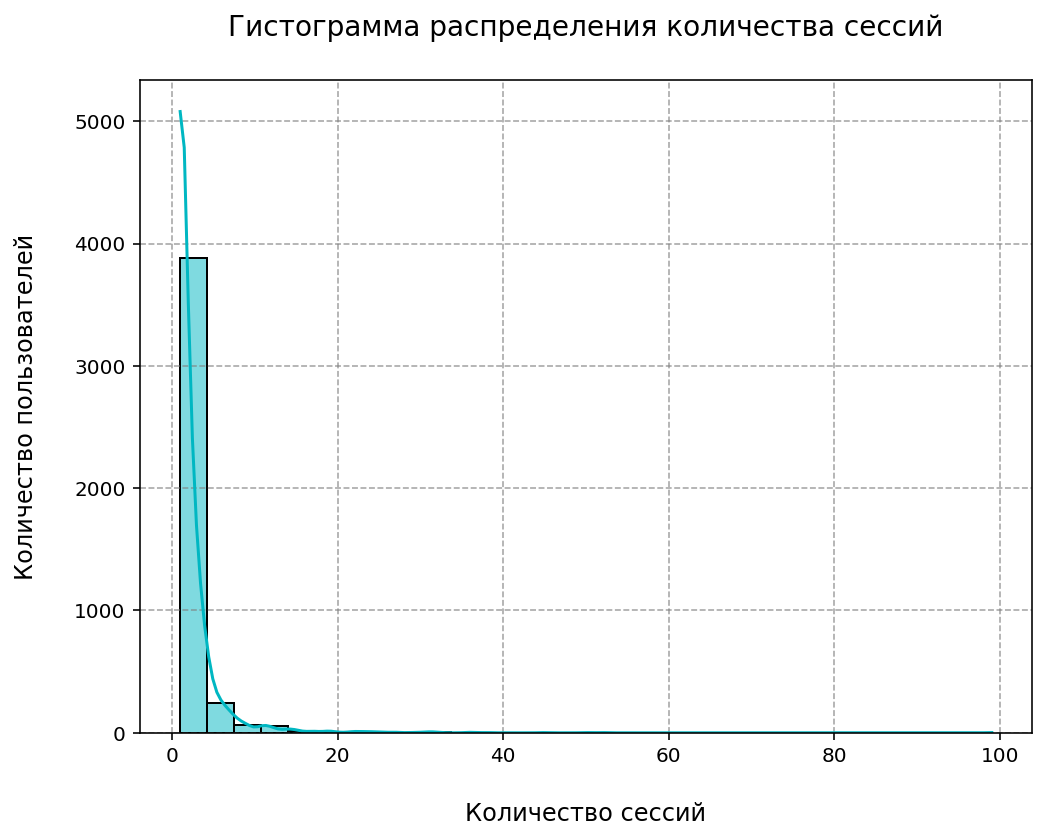

In [40]:
# Гистограмма распределения количества сессий

plt.figure(figsize=(8, 6))
sns.histplot(mobile_full_session_cnt['session_cnt'], bins=30, kde=True, color='#00b7c2')
plt.title('Гистограмма распределения количества сессий\n', fontsize=14)
plt.xlabel('\nКоличество сессий', fontsize=12)
plt.ylabel('Количество пользователей\n', fontsize=12)
plt.grid(linestyle='--', color='gray', alpha=0.7)
plt.show()

📌 **Выводы:**
* Гистограмма подтверждает вышесказанное: почти 4000 пользователей (из 4293) совершили в приложении от 1 до 4 сессий. 

#### Сезонность сессий

Проанализируем, как пользователи взаимодействуют с приложением **в течение суток**. 

Добавим новый столбец `hour_of_start`, в котором выделим время начала сессии:

In [41]:
mobile_full_first['hour_of_start'] = mobile_full_first['event_time'].dt.hour

/tmp/ipykernel_63/4006974609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobile_full_first['hour_of_start'] = mobile_full_first['event_time'].dt.hour


In [42]:
mobile_full_first.head()

,event_time,event_name,user_id,source,session_id,session_duration,returned,contacts_viewed,hour_of_start
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1,0,13
9,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,507.385985,1,0,18
13,2019-10-21 19:52:30.778932,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,3,899.272096,1,0,19
27,2019-10-22 11:18:14.635436,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,4,758.171767,1,0,11
35,2019-10-19 21:34:33.849769,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,1,1520.787329,1,0,21


In [43]:
# сводная таблица продолжительности сессий по часам

session_duration_day = mobile_full_first.groupby('hour_of_start', as_index=False).agg({'session_duration':'sum'})

# сводная таблица количества сессий по часам

session_day_cnt = mobile_full_first.groupby('hour_of_start', as_index=False).agg({'session_duration':'count'})

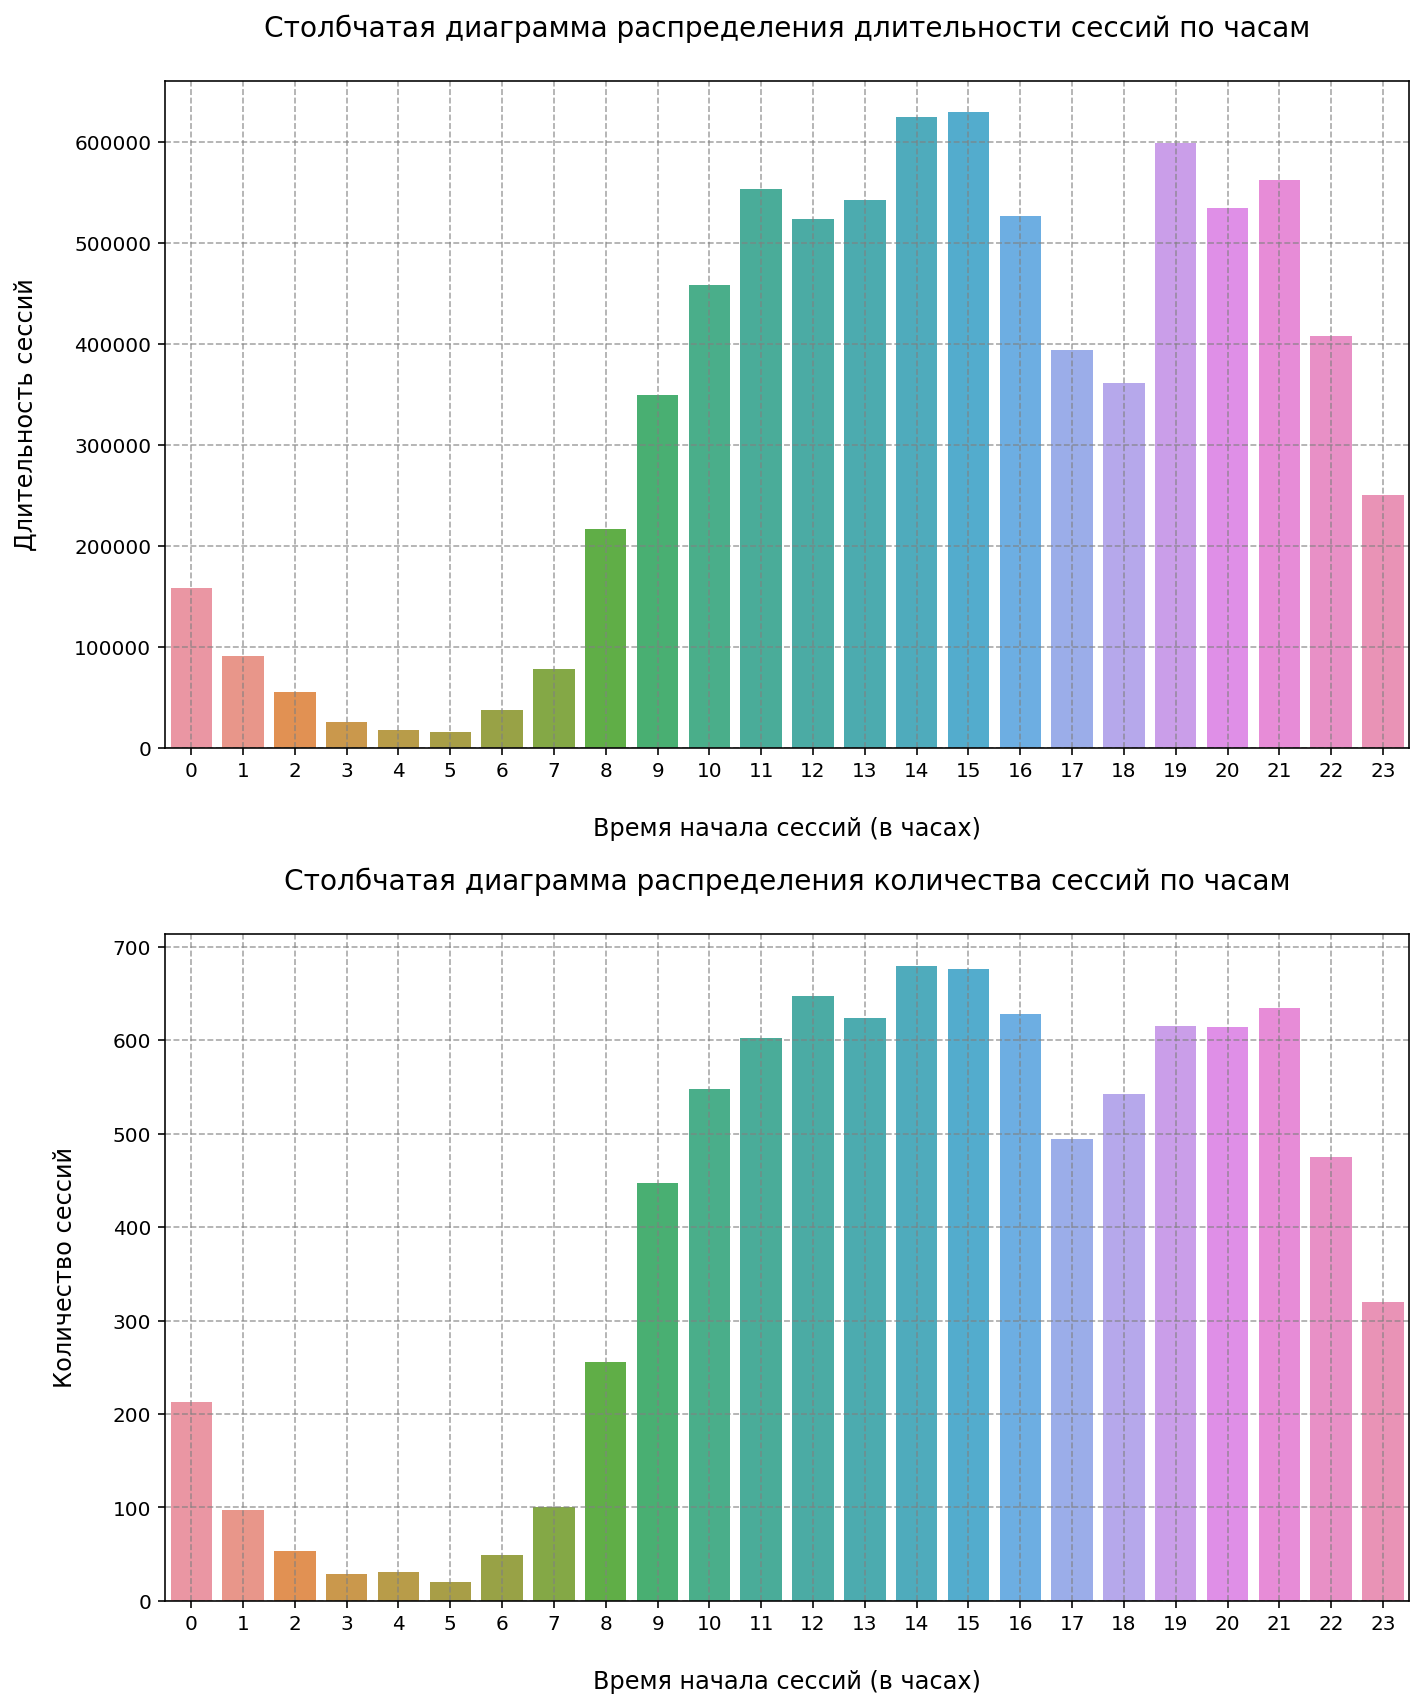

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Столбчатая диаграмма распределения длительности сессий по часам

sns.barplot(data=session_duration_day, x='hour_of_start', y='session_duration', ax=axs[0])
axs[0].set_title('Столбчатая диаграмма распределения длительности сессий по часам\n', fontsize=14)
axs[0].set_xlabel('\nВремя начала сессий (в часах)', fontsize=12)
axs[0].set_ylabel('Длительность сессий\n', fontsize=12)
axs[0].grid(linestyle='--', color='gray', alpha=0.7)

# Столбчатая диаграмма распределения количества сессий по часам

sns.barplot(data=session_day_cnt, x='hour_of_start', y='session_duration', ax=axs[1])
axs[1].set_title('Столбчатая диаграмма распределения количества сессий по часам\n', fontsize=14)
axs[1].set_xlabel('\nВремя начала сессий (в часах)', fontsize=12)
axs[1].set_ylabel('Количество сессий\n', fontsize=12)
axs[1].grid(linestyle='--', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

📌 **Выводы:**
* Дольше всего приложение используют пользователи, начинающие сессию **в 14 и 15 часов**, а также **19 часов**;
* Больше всего сессий начинаются **в 14 и 15 часов**, а также **в 12 и 21 час**. 

Проанализируем, как пользователи взаимодействуют с приложением по дням недели: 

Добавим новый столбец `day_of_week`, в котором выделим день недели сессии:

In [45]:
mobile_full_first['day_of_week'] = mobile_full_first['event_time'].dt.weekday

/tmp/ipykernel_63/2186780276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobile_full_first['day_of_week'] = mobile_full_first['event_time'].dt.weekday


In [46]:
mobile_full_first.head()

,event_time,event_name,user_id,source,session_id,session_duration,returned,contacts_viewed,hour_of_start,day_of_week
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,595.727258,1,0,13,0
9,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,507.385985,1,0,18,2
13,2019-10-21 19:52:30.778932,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,3,899.272096,1,0,19,0
27,2019-10-22 11:18:14.635436,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,4,758.171767,1,0,11,1
35,2019-10-19 21:34:33.849769,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,1,1520.787329,1,0,21,5


In [47]:
# сводная таблица продолжительности сессий по дням недели

session_duration_dow = mobile_full_first.groupby('day_of_week', as_index=False).agg({'session_duration':'sum'})

# сводная таблица количества сессий по дням недели

session_dow_cnt = mobile_full_first.groupby('day_of_week', as_index=False).agg({'session_duration':'count'})

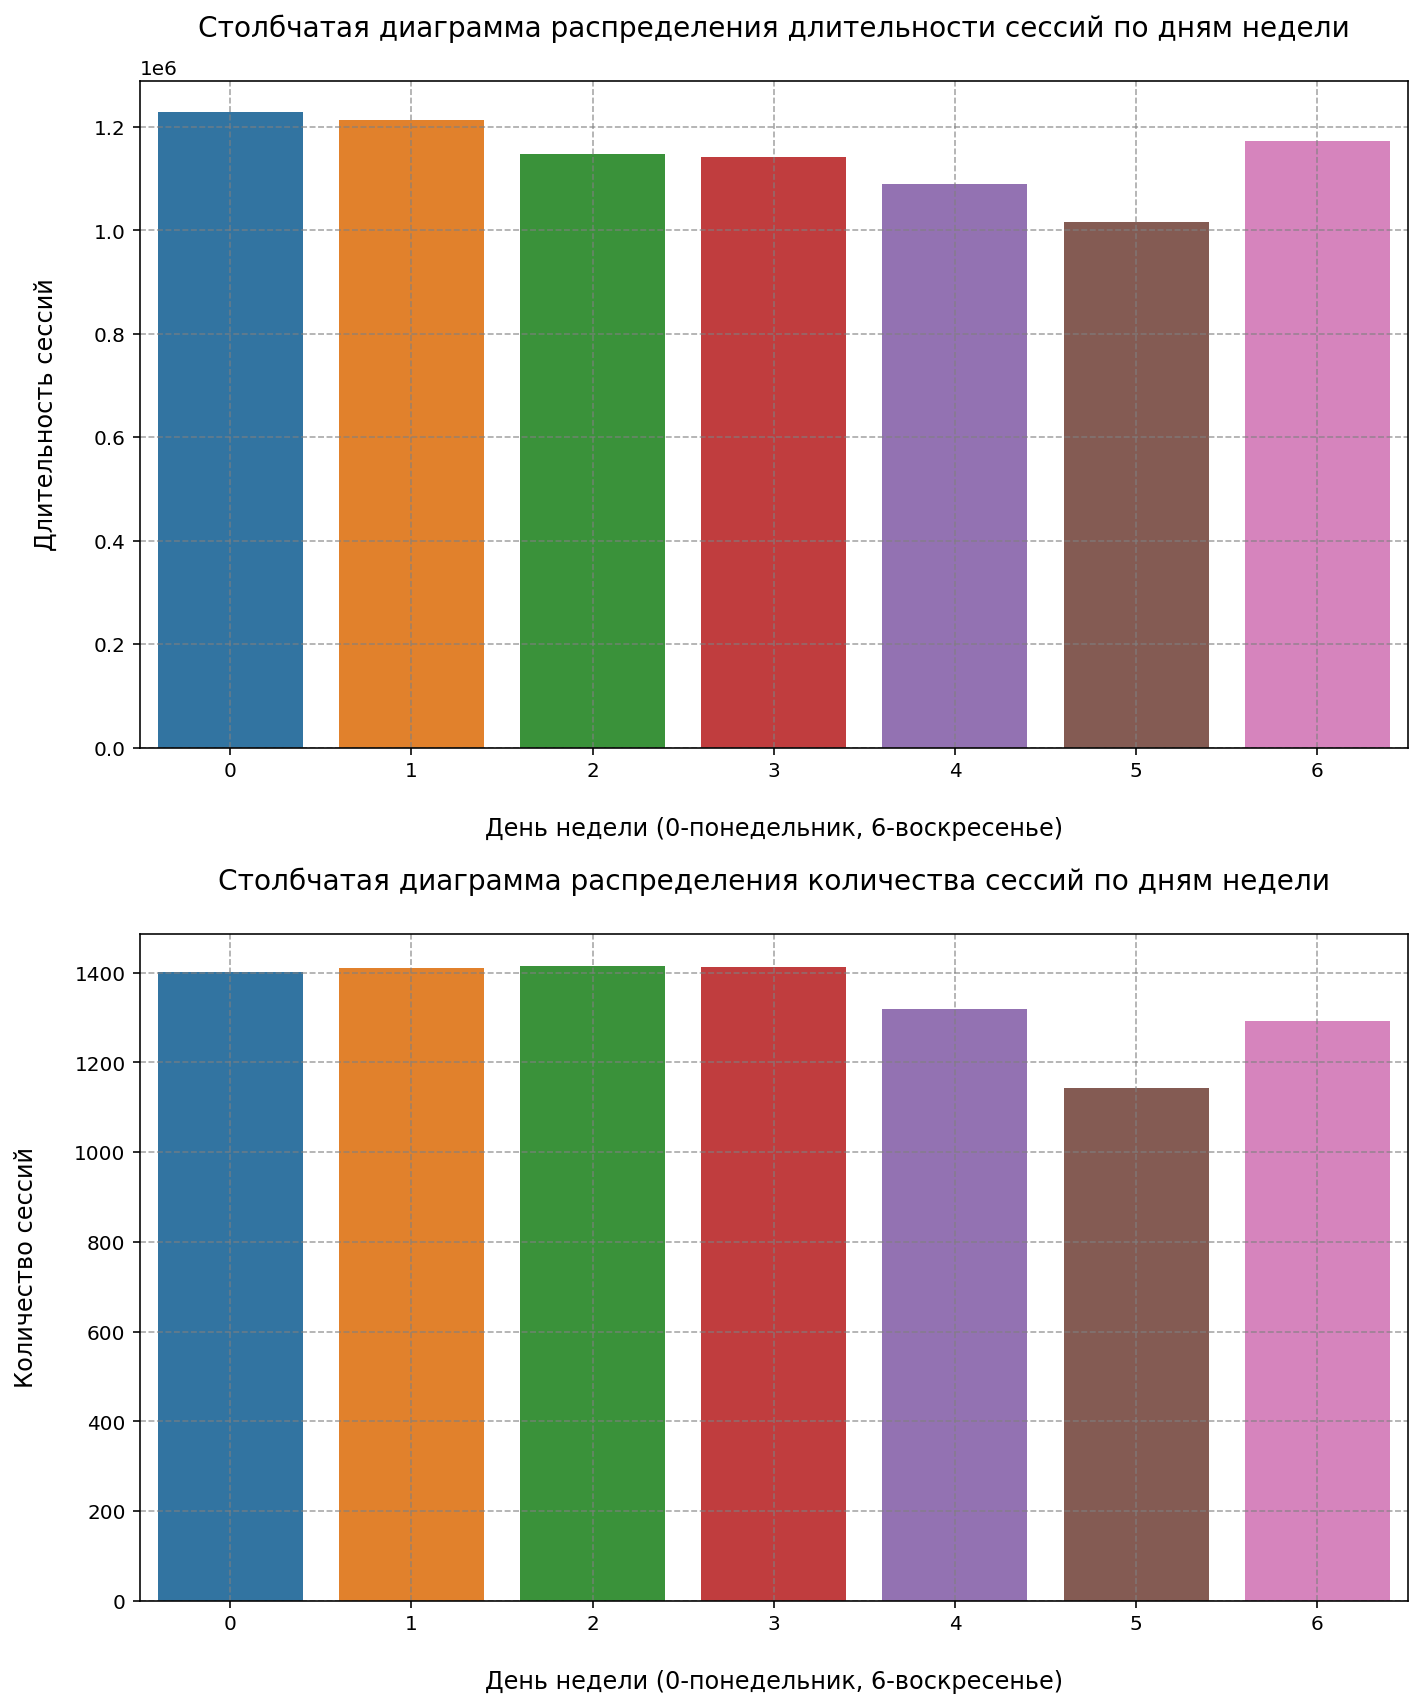

In [48]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Столбчатая диаграмма распределения длительности сессий по дням недели

sns.barplot(data=session_duration_dow, x='day_of_week', y='session_duration', ax=axs[0])
axs[0].set_title('Столбчатая диаграмма распределения длительности сессий по дням недели\n', fontsize=14)
axs[0].set_xlabel('\nДень недели (0-понедельник, 6-воскресенье)', fontsize=12)
axs[0].set_ylabel('Длительность сессий\n', fontsize=12)
axs[0].grid(linestyle='--', color='gray', alpha=0.7)

# Столбчатая диаграмма распределения количества сессий по дням недели

sns.barplot(data=session_dow_cnt, x='day_of_week', y='session_duration', ax=axs[1])
axs[1].set_title('Столбчатая диаграмма распределения количества сессий по дням недели\n', fontsize=14)
axs[1].set_xlabel('\nДень недели (0-понедельник, 6-воскресенье)', fontsize=12)
axs[1].set_ylabel('Количество сессий\n', fontsize=12)
axs[1].grid(linestyle='--', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

📌 **Выводы:**
* Дольше всего приложение используют пользователи по **понедельникам, вторникам и воскресеньям** – то есть в начале и конце рабочей недели. 
* При этом наибольшее количество сессий достигается во вторник, а также **с понедельника по четверг**. 
* Можно сделать вывод, что в воскресенье меньше пользователей используют приложение, но те, кто используют, делают это основательно и вовлеченно. В понедельник и вторник много пользователей используют приложение и делают это продолжительно. В среду и четверг количество пользователей, испольщующих приложение, достаточно высокое, однако времени на приложение они тратят меньше. 

### Анализ частоты событий

Объединим события search_1 - search_7, связанные с поиском по сайту в одно *search_action*:

In [49]:
mobile_full['event_name'] = mobile_full['event_name'].replace(to_replace='search.*', value='search_action', regex=True)

Объединим события contacts_show и show_contacts, связанные с просмотром контактов в одно действие *contacts_show*:

In [50]:
mobile_full['event_name'] = mobile_full['event_name'].replace(to_replace='.*contacts.*', value='contacts_show', regex=True)

Посчитаем частоту каждого вида событий:

In [51]:
event_counts = mobile_full['event_name'].value_counts()
event_counts

tips_show        40055
photos_show      10012
search_action     6784
advert_open       6164
contacts_show     5070
map               3881
favorites_add     1417
tips_click         814
Name: event_name, dtype: int64

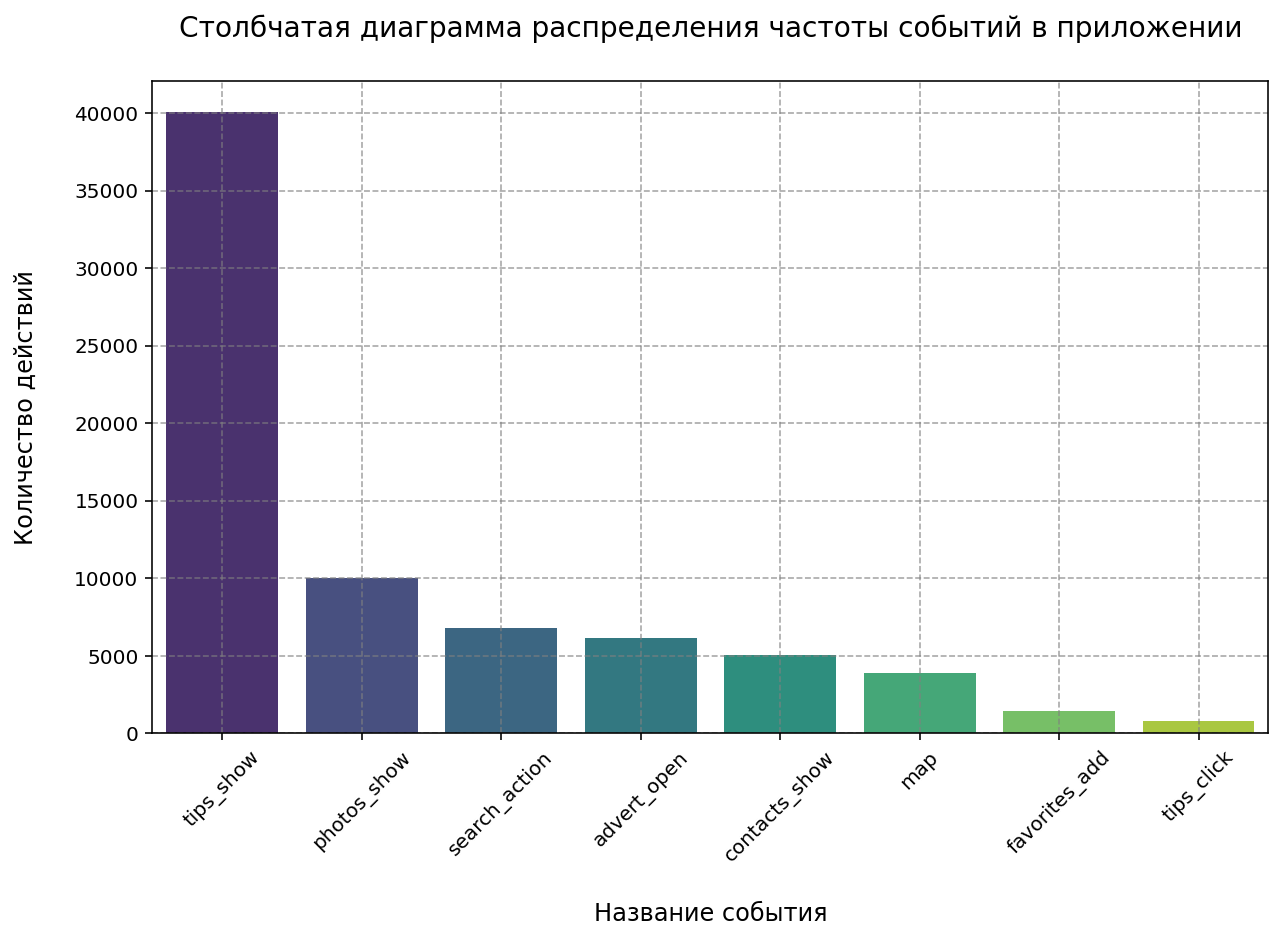

In [52]:
# столбчатая диаграмма распределения частоты событий в приложении

plt.figure(figsize=(10, 6))
sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')
plt.title('Столбчатая диаграмма распределения частоты событий в приложении\n', fontsize=14)
plt.xlabel('\nНазвание события', fontsize=12)
plt.ylabel('Количество действий\n', fontsize=12)
plt.xticks(rotation=45)
plt.grid(linestyle='--', color='gray', alpha=0.7)
plt.show()

📌 **Выводы:**
* Наибольшее количество событий связано с **tips_show - просмотром рекомендованных объявлений**. Также в топ-3 действий входят **photos_show** (просмотр фотографий объявления) и **search_action** (различные действия, связанные с поиском по сайту; 
* Меньше всего событий связано с **tips_click** (клик по рекомендованному объявлению) и **favorites_add** (добавление объявления в избранное). Стоит проанализировать текущие **алгоритмы рекомендаций**, чтобы показывать более релевантные объявления. А также подумать над тестированием различных форматов отображения рекомендованных объявлений. 

#### Анализ частоты событий внутри каждой сессии 

Создадим таблицу, подсчитывающую количество действий внутри каждой сессии для каждого пользователя:

In [53]:
session_activity = mobile_full.groupby(['user_id', 'session_id'])\
.agg({'event_name':'count'})\
.rename(columns={'event_name':'event_cnt'})

session_activity.head()

event_cnt
user_id                              session_id           
0001b1d5-b74a-4cbf-aeb0-7df5947bf349 1                   9
                                     2                   4
                                     3                  14
                                     4                   8
00157779-810c-4498-9e05-a1e9e3cedf93 1                   9

Проанализируем описательные статистики, связанные с количеством действий внутри сессии:

In [54]:
session_activity['event_cnt'].describe()

count    10368.000000
mean         7.156346
std          9.581106
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        149.000000
Name: event_cnt, dtype: float64

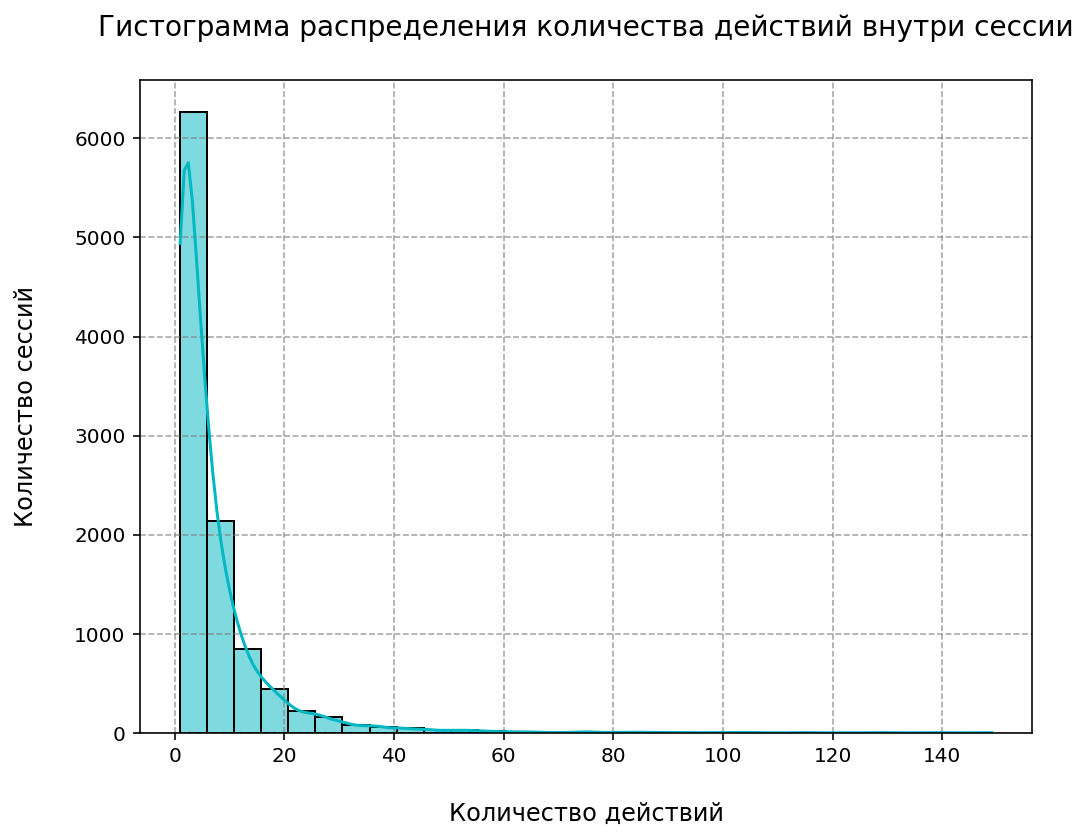

In [55]:
# Гистограмма распределения количества действий внутри сессии

plt.figure(figsize=(8, 6))
sns.histplot(session_activity['event_cnt'], bins=30, kde=True, color='#00b7c2')
plt.title('Гистограмма распределения количества действий внутри сессии\n', fontsize=14)
plt.xlabel('\nКоличество действий', fontsize=12)
plt.ylabel('Количество сессий\n', fontsize=12)
plt.grid(linestyle='--', color='gray', alpha=0.7)
plt.show()

📌 **Выводы:**
* Среднее количество действий внутри одной сессии равно 7, а медианное равно 4. Разница в показателях сигнализирует о наличии аномальных значений – пользователей с очень высокой, и наоборот, очень низкой активностью;
* Половина пользователей приложения совершает 4 действия во время его использования;
* Минимальное количество действий внутри одной сессии в приложении равно 1, что указывает на низкую вовлеченность и плохую удерживаемость данной категории пользователей;
* Максимальное количество действий внутри одной сессии равно 149. 

Добавим к составленной таблице колонку `event_time`, чтобы проанализировать вовлеченность пользователей по дням / дням недели / часам: 

In [56]:
# Добавление столбца с временем 

session_activity = session_activity\
.merge(mobile_full, how='left', on='user_id')[['user_id', 'session_id','event_cnt', 'event_time']]

# Добавление столбцов с временными характеристиками: день недели, часы

session_activity['event_hour'] = session_activity['event_time'].dt.hour
session_activity['event_dow'] = session_activity['event_time'].dt.weekday
session_activity = session_activity.drop_duplicates(subset=['user_id', 'session_id'])

In [57]:
session_activity.head()

,user_id,session_id,event_cnt,event_time,event_hour,event_dow
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,9,2019-10-07 13:39:45.989359,13,0
9,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,9,2019-10-09 18:33:55.577963,18,2
13,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,9,2019-10-21 19:52:30.778932,19,0
27,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,9,2019-10-22 11:18:14.635436,11,1
140,00157779-810c-4498-9e05-a1e9e3cedf93,1,9,2019-10-19 21:34:33.849769,21,5


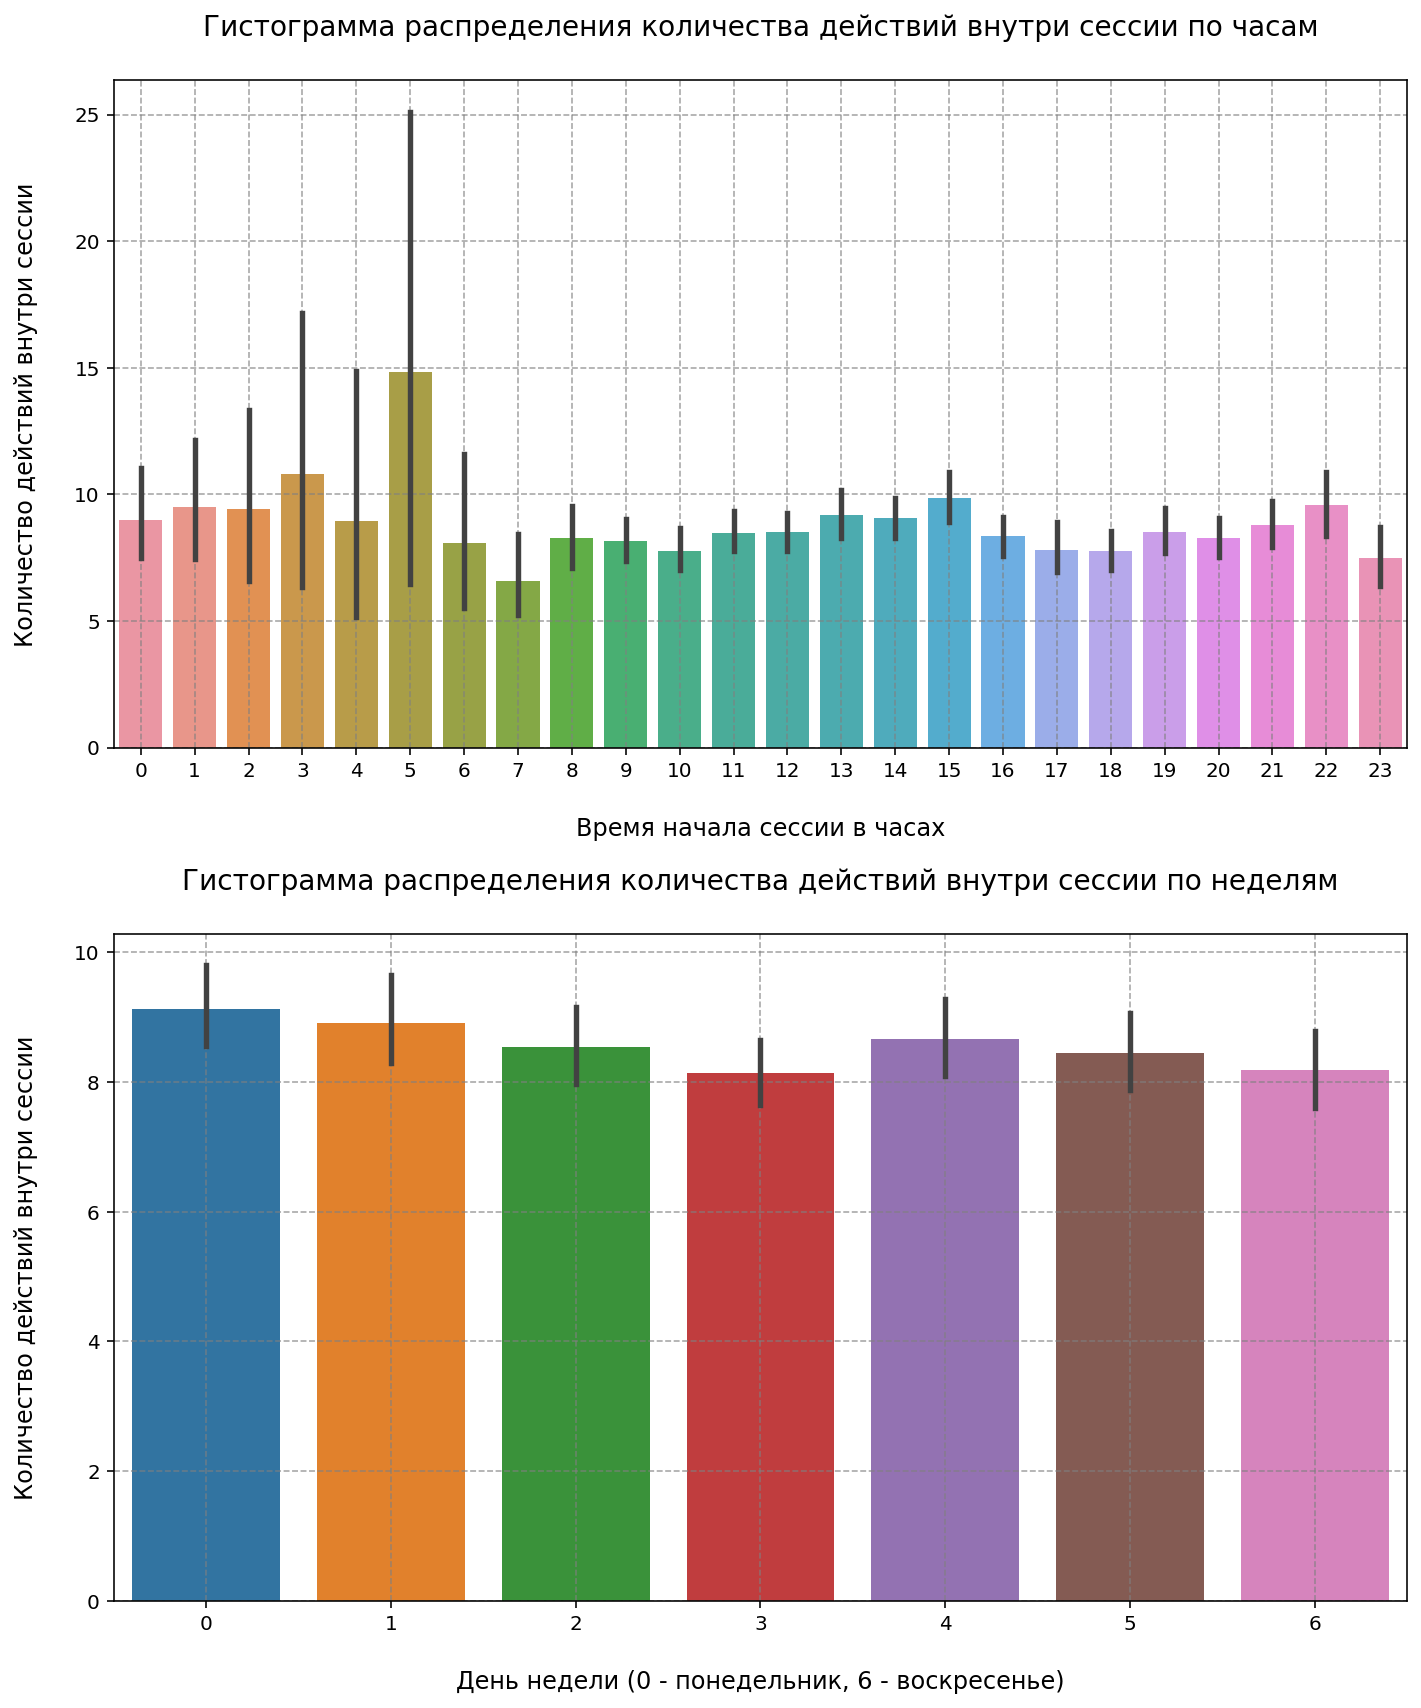

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Гистограмма распределения количества действий внутри сессии по часам

sns.barplot(data=session_activity, x='event_hour', y='event_cnt', ax=axs[0])
axs[0].set_title('Гистограмма распределения количества действий внутри сессии по часам\n', fontsize=14)
axs[0].set_xlabel('\nВремя начала сессии в часах', fontsize=12)
axs[0].set_ylabel('Количество действий внутри сессии\n', fontsize=12)
axs[0].grid(linestyle='--', color='gray', alpha=0.7)

# Гистограмма распределения количества действий внутри сессии по неделям

sns.barplot(data=session_activity, x='event_dow', y='event_cnt', ax=axs[1])
axs[1].set_title('Гистограмма распределения количества действий внутри сессии по неделям\n', fontsize=14)
axs[1].set_xlabel('\nДень недели (0 - понедельник, 6 - воскресенье)', fontsize=12)
axs[1].set_ylabel('Количество действий внутри сессии\n', fontsize=12)
axs[1].grid(linestyle='--', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

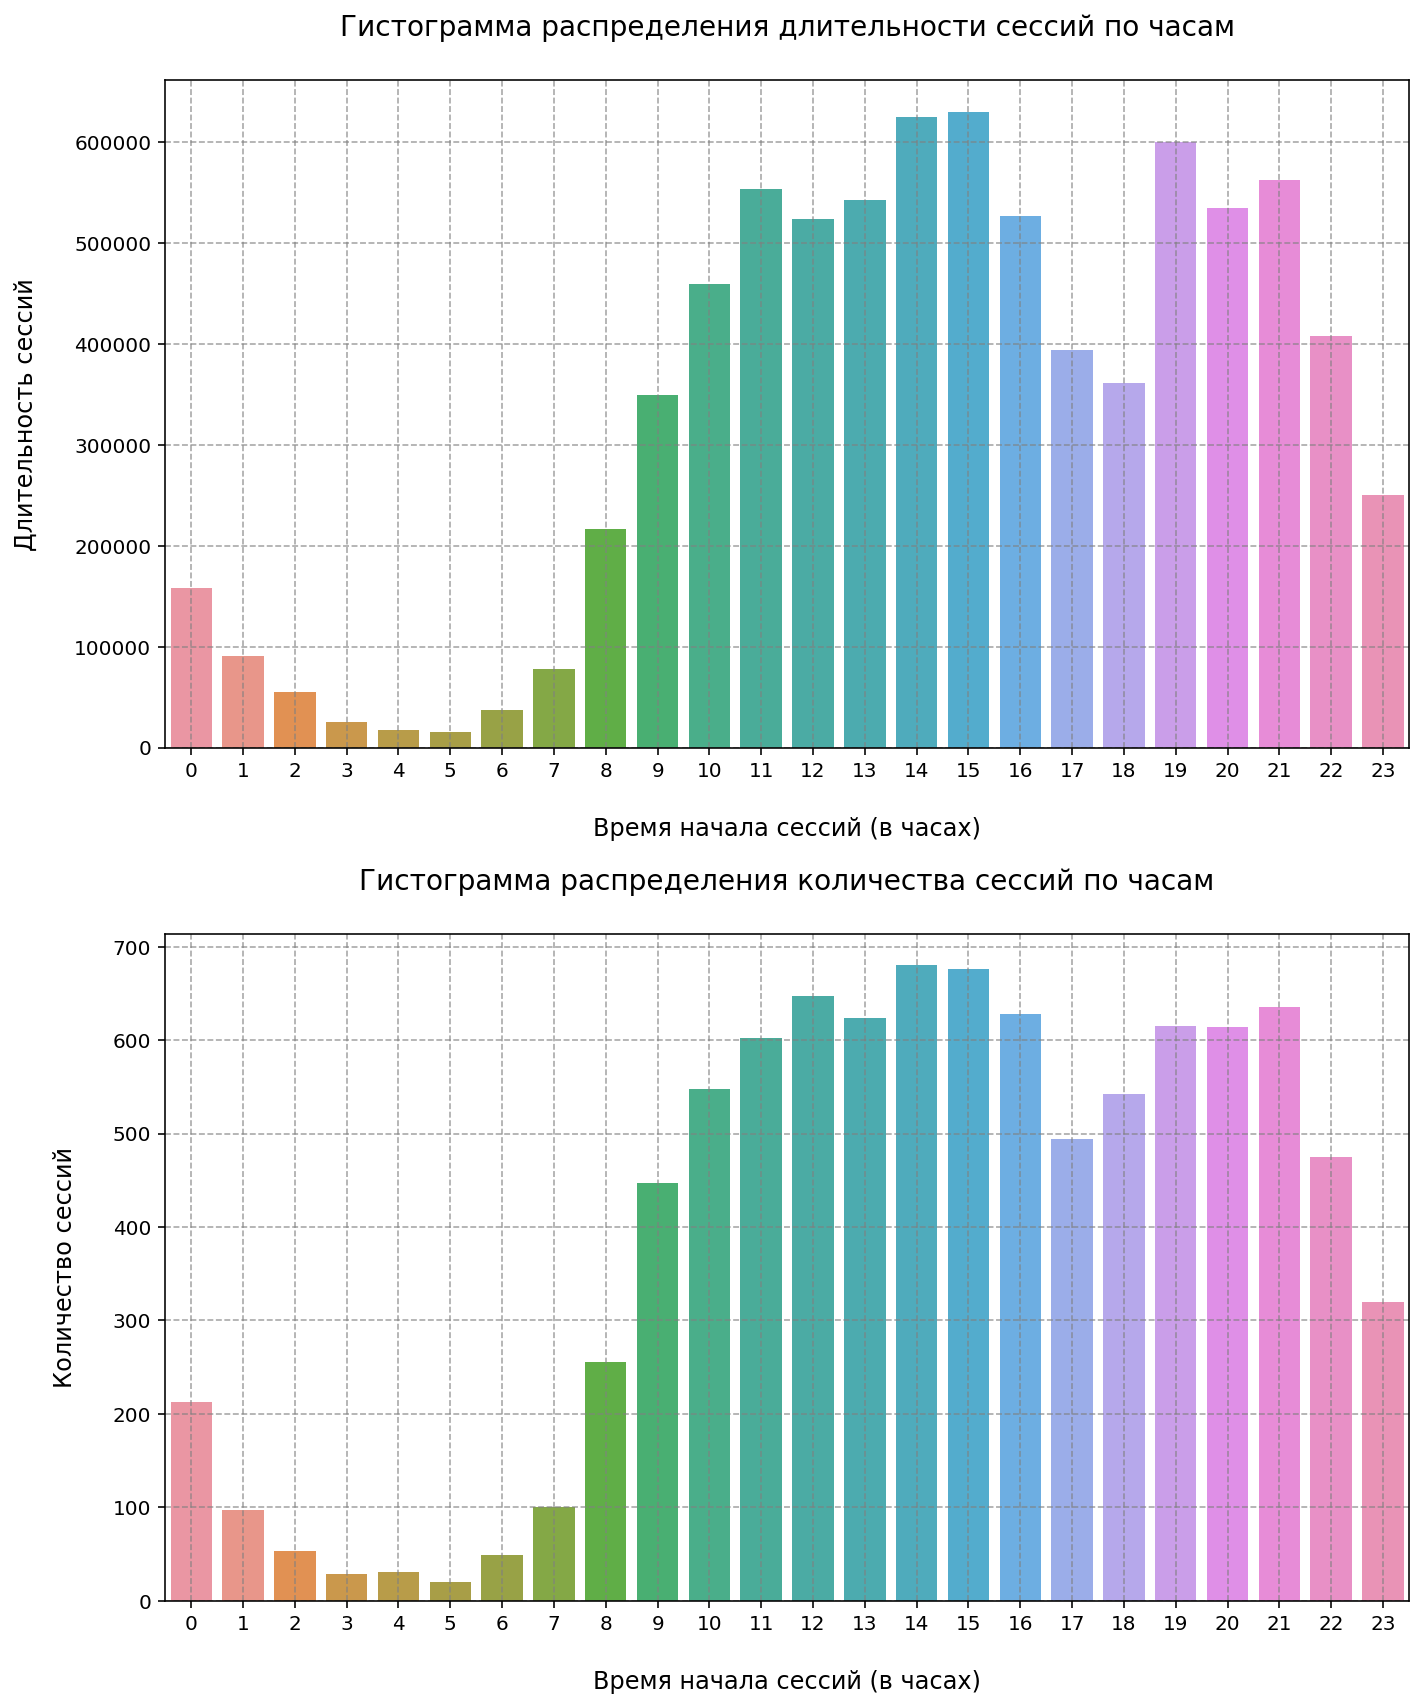

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Гистограмма распределения количества действий внутри сессии по часам

sns.barplot(data=session_duration_day, x='hour_of_start', y='session_duration', ax=axs[0])
axs[0].set_title('Гистограмма распределения длительности сессий по часам\n', fontsize=14)
axs[0].set_xlabel('\nВремя начала сессий (в часах)', fontsize=12)
axs[0].set_ylabel('Длительность сессий\n', fontsize=12)
axs[0].grid(linestyle='--', color='gray', alpha=0.7)

# Гистограмма распределения количества сессий по часам

sns.barplot(data=session_day_cnt, x='hour_of_start', y='session_duration', ax=axs[1])
axs[1].set_title('Гистограмма распределения количества сессий по часам\n', fontsize=14)
axs[1].set_xlabel('\nВремя начала сессий (в часах)', fontsize=12)
axs[1].set_ylabel('Количество сессий\n', fontsize=12)
axs[1].grid(linestyle='--', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

📌 **Выводы:**
* Как ни странно, наибольшую вовлеченность в приложение показывают пользователи, которые начинают сессию **в 5 утра**: они в среднем выполняют около 15 действий. В 3 часа ночи, 15 часов дня и 22 часа вечера пользователи совершают порядка 10 действий. Наименее активно приложение используют пользователи, сессии которых начинаются в 7 утра;
* В течение недели наиболее активно взаимодействуют с приложением пользователи **по понедельникам, вторникам и пятницам**. 

### Анализ конверсии в действие "Просмотр контактов"

Подсчитаем общее количество клиентов:

In [60]:
# Общее количество клиентов

total_clients = mobile_full['user_id'].unique().shape[0]
print(f'Суммарное количество клиенов - {total_clients}')

Суммарное количество клиенов - 4293


Подсчитаем количество клиентов, которые совершили целевое действие:

In [61]:
# Количество клиентов, совершивших целевое действие

cr_clients = mobile_full.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
print(f'Количество клиентов, совершивших целевое действие "Просмотр контактов" - {cr_clients}')

Количество клиентов, совершивших целевое действие "Просмотр контактов" - 981


In [62]:
# Подсчет конверсии

cr = round(cr_clients*100 / total_clients, 2)
print(f'Конверсия в действие "просмотр контактов" составляет ≈{cr}%')

Конверсия в действие "просмотр контактов" составляет ≈22.85%


📌 **Выводы:**
* Всего за рассматриваемый период в приложении зарегистрировались 4293 пользователя. При этом только 981 пользователь совершил целевое действие "просмотр контактов". Таким образом конверсия в целевое действие составляет ≈22.85%;
* Значение конверсии низкое. Оно может указывать на проблемы в пользовательском опыте или недостаточную привлекательность целевого действия.

## Сегментация пользователей на основе количества действий

Проведем сегментацию пользователей по уровню их вовлеченности – суммарному количеству действий, совершенных в приложении.

Такая сегментация может помочь в:
* разработке стратегий для повышения вовлеченности и удержания;
* адаптации контента и предложений;
* приоретизации функций для развития, опираясь на действия активных пользователей. 

Можно предположить, что количество действий положительно влияет и на удержание пользователей в приложении, и на конверсию в целевое действие. 

Для начала выделим датасет, в котором зафиксируем, какое количество действий приходится на каждого пользователя:

In [63]:
activity_by_users = mobile_full.groupby('user_id')\
.agg({'event_name':'count'})\
.rename(columns={'event_name':'event_cnt'})
activity_by_users.head()

,event_cnt
user_id,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
00157779-810c-4498-9e05-a1e9e3cedf93,71
00463033-5717-4bf1-91b4-09183923b9df,10
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
00551e79-152e-4441-9cf7-565d7eb04090,8


Проанализируем описательные статистики столбца event_name для собранного датасета:

In [64]:
activity_by_users['event_cnt'].describe()

count    4293.000000
mean       17.283252
std        29.130677
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       478.000000
Name: event_cnt, dtype: float64

📌 **Выводы:**
* В среднем пользователи приложения совершают 17 действий. Данная величина значительно отличается от медианной (9 действий), что указывает на большой разброс значений: есть как очень активные пользователи, так и наоборот;
* Половина всех пользователей в приложении совершает не более 9 действий;
* Минимальное количество действий, совершенных в приложении, равно 1, а максимальное – 478. 

Будем использовать **квартили** для сегментации клиентов: 
* Сегмент 1 - пользователи с низким уровнем активности (количество действий ниже 5 (1-й квартиль));
* Сегмент 2 - пользователи со средним уровнем активности (количество действий от 5 до 17 (между 1-м и 3-м квартилями));
* Сегмент 3 - пользователи с высоким уровнем активности (количество действий выше 17 (3-й квартиль и выше)).

In [65]:
quantile_50 = np.percentile(activity_by_users['event_cnt'], 50)
quantile_75 = np.percentile(activity_by_users['event_cnt'], 75)

In [66]:
# Формирование сегментов 

activity_by_users_low = activity_by_users.query('event_cnt <= @quantile_50')
activity_by_users_medium = activity_by_users.query('@quantile_50 < event_cnt < @quantile_75')
activity_by_users_high = activity_by_users.query('event_cnt >= @quantile_75')

In [84]:
len(activity_by_users_low) + len(activity_by_users_medium) + len(activity_by_users_high)



4293

### Анализ Retention Rate для каждого сегмента

Объединим таблицы с выделенными сегментами с первоначальной таблицей сессий:

In [67]:
# Возврат к первоначальным таблицам для каждого сегмента

mobile_full_low = mobile_full.merge(activity_by_users_low, how='inner', on='user_id')
mobile_full_medium = mobile_full.merge(activity_by_users_medium, how='inner', on='user_id')
mobile_full_high = mobile_full.merge(activity_by_users_high, how='inner', on='user_id')

Для каждого сегмента построим таблицу удержания, в которой отразим:
* дату формирования когорты по дате первого посещению приложения
* долю вернувшихся пользователей для каждой когорты

Для исследования показателя Renetion Rate мобильного приложения примем за горизонт анализа также 7 дней. Используем уже ранее созданные функции:

In [68]:
profiles_low = get_profiles(mobile_full_low)
profiles_medium = get_profiles(mobile_full_medium)
profiles_high = get_profiles(mobile_full_high)

In [69]:
retention_raw_low, retention_low = get_retention(profiles_low, mobile_full_low, datetime(2019, 11, 3).date(), 7)
retention_raw_medium, retention_medium = get_retention(profiles_medium, mobile_full_medium, datetime(2019, 11, 3).date(), 7)
retention_raw_high, retention_high = get_retention(profiles_high, mobile_full_high, datetime(2019, 11, 3).date(), 7)

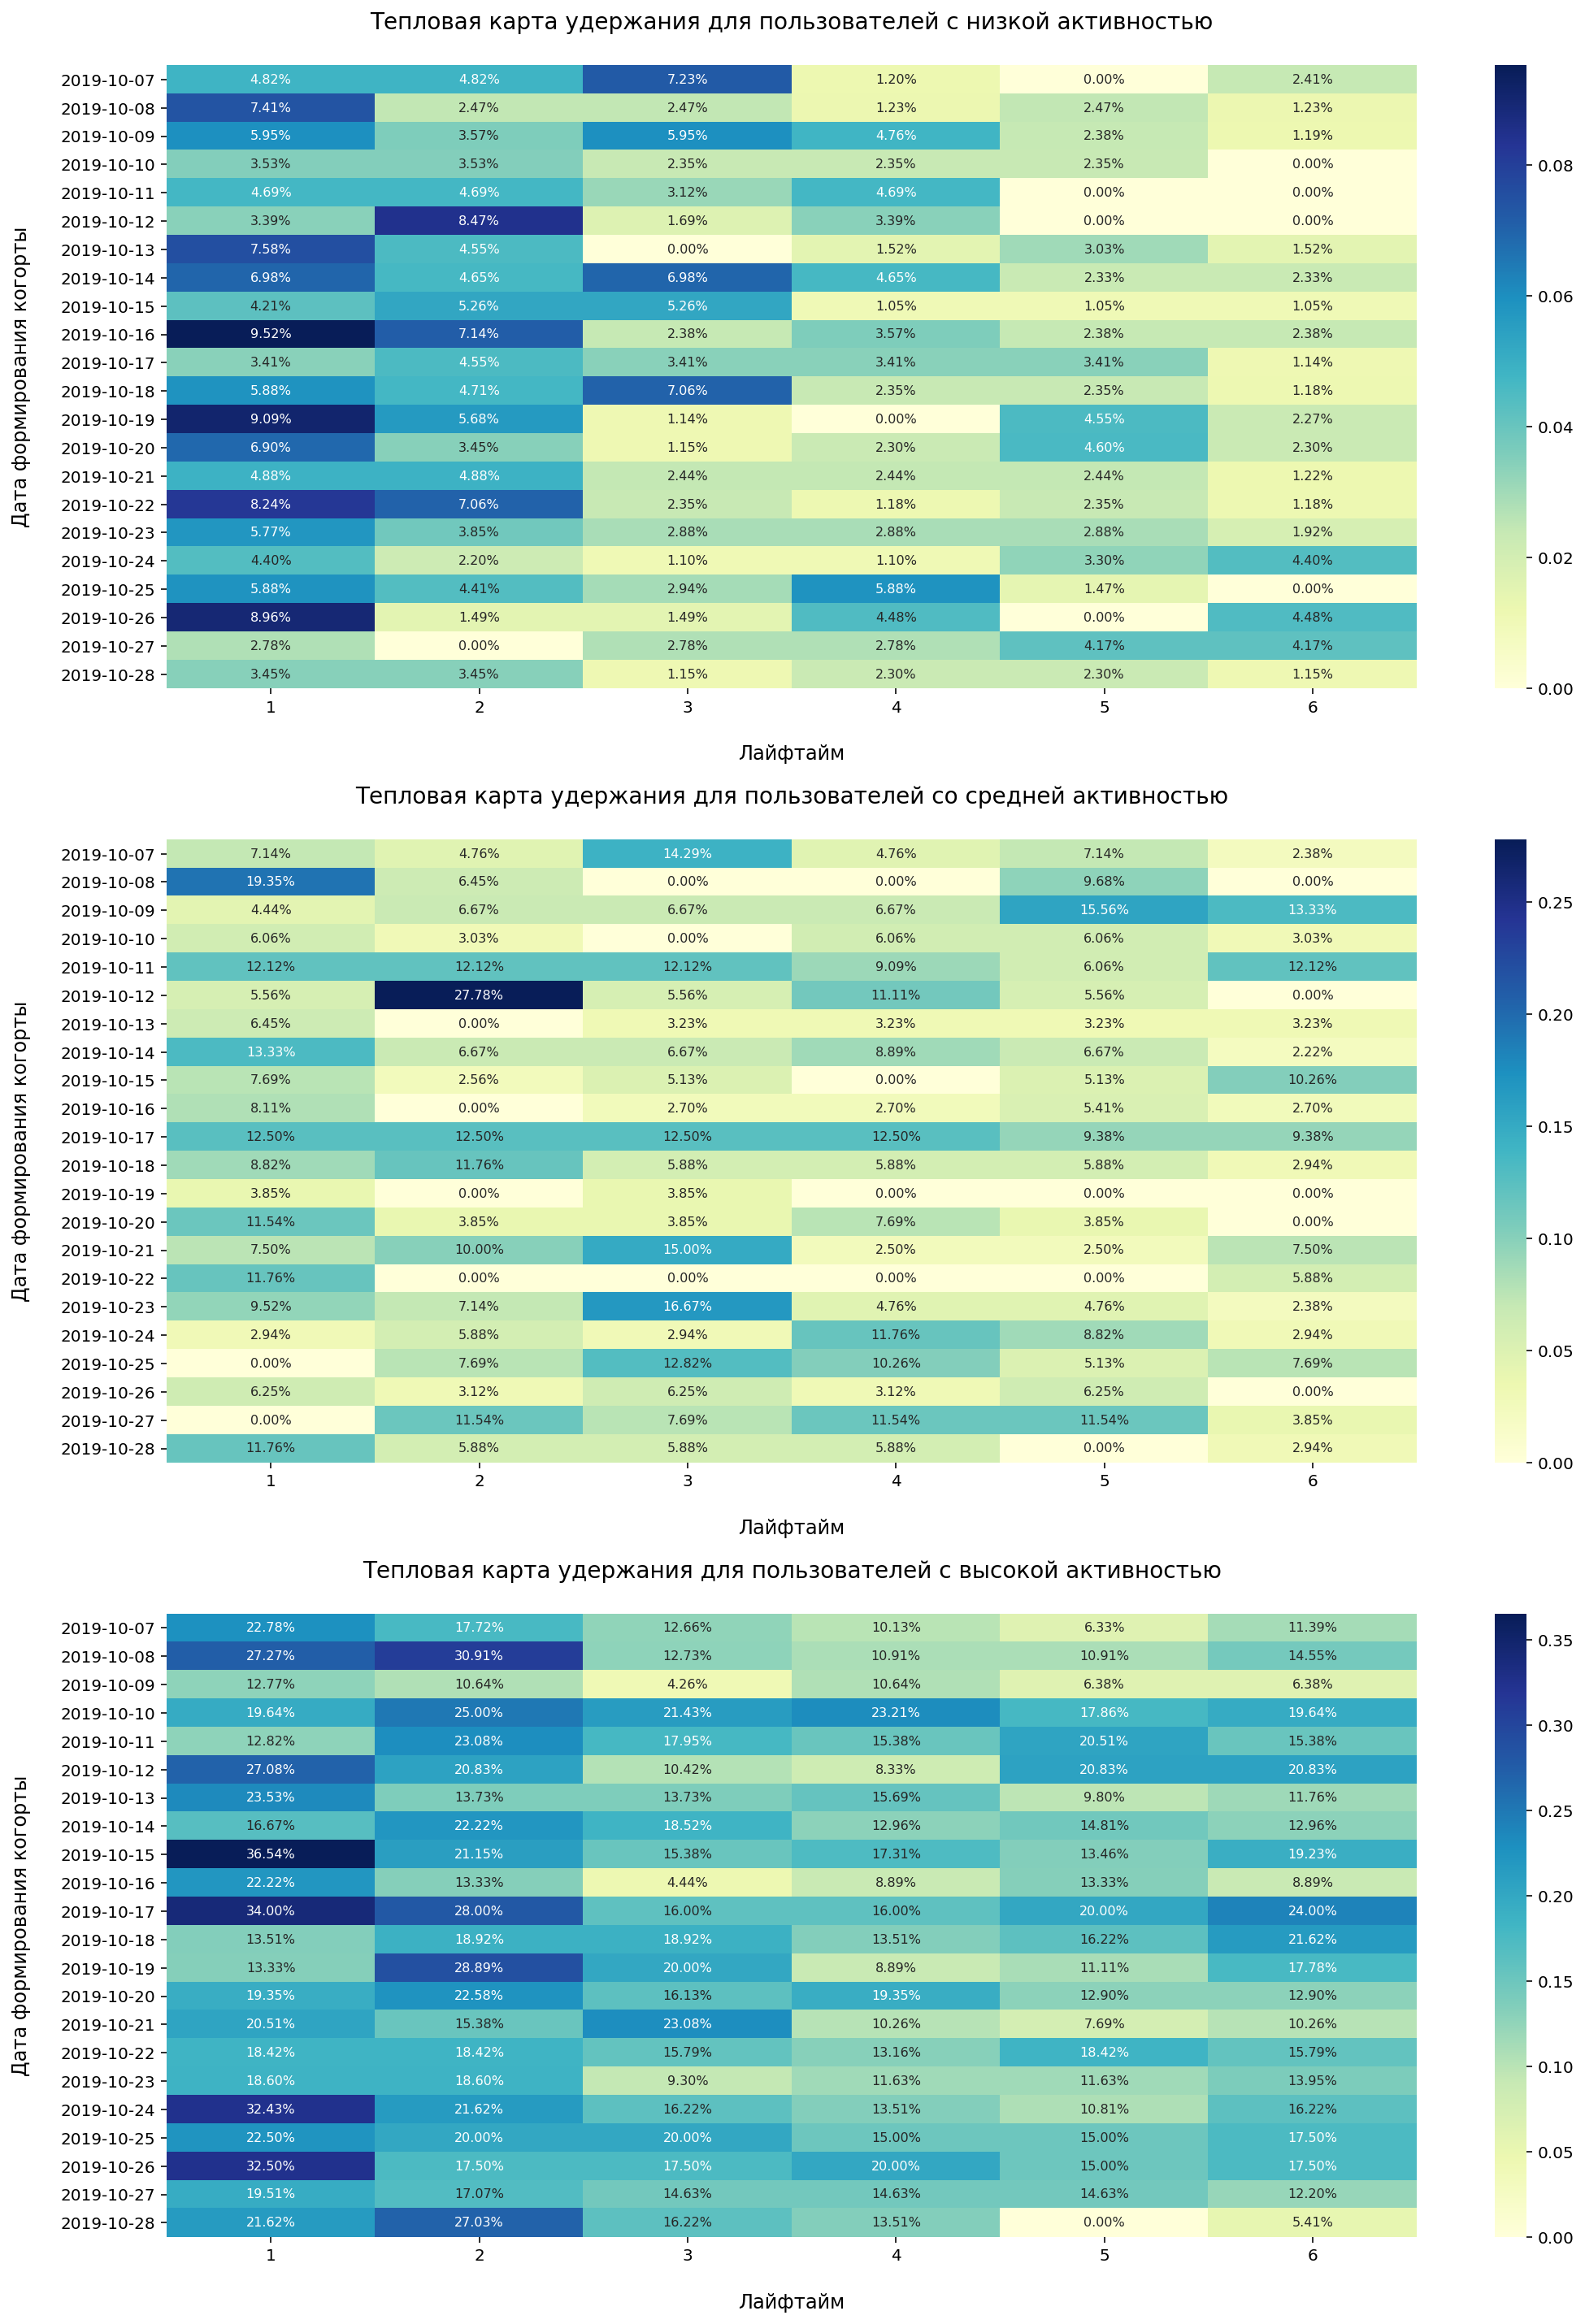

In [70]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))

# Тепловая карта удержания для пользователей с низкой активностью
sns.heatmap(retention_low.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%', cmap='YlGnBu', ax=axs[0], annot_kws={"size": 8})
axs[0].set_title('Тепловая карта удержания для пользователей с низкой активностью\n', fontsize=14)
axs[0].set_xlabel('\nЛайфтайм', fontsize=12)
axs[0].set_ylabel('Дата формирования когорты\n', fontsize=12)

# Тепловая карта удержания для пользователей со средней активностью
sns.heatmap(retention_medium.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%', cmap='YlGnBu', ax=axs[1], annot_kws={"size": 8})
axs[1].set_title('Тепловая карта удержания для пользователей со средней активностью\n', fontsize=14)
axs[1].set_xlabel('\nЛайфтайм', fontsize=12)
axs[1].set_ylabel('Дата формирования когорты\n', fontsize=12)

# Тепловая карта удержания для пользователей с высокой активностью
sns.heatmap(retention_high.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%', cmap='YlGnBu', ax=axs[2], annot_kws={"size": 8})
axs[2].set_title('Тепловая карта удержания для пользователей с высокой активностью\n', fontsize=14)
axs[2].set_xlabel('\nЛайфтайм', fontsize=12)
axs[2].set_ylabel('Дата формирования когорты\n', fontsize=12)

plt.tight_layout()
plt.show()

📌 **Выводы:**
* Удержание пользователей с низкой активностью на первый день колеблется от 2.78% до 9.52%. Для пользователей со средней активностью – от 0% до 19.35%. Для пользователей с высокой активностью – от 12.77% до 34%;
* Удержание пользователей с низкой активностью на седьмой день не превышает 4.48%. Для пользователей со средней активностью - колеблется от 0% до 13.33%. Для пользователей с высокой активностью – колеблется от 5.41% до 24%;
* Пользователи, которые активно взаимодействуют с приложением и совершают в нем много действий, удерживаются дольше. 

###  Анализ конверсии в просмотр контактов

Посчитаем конверсию в целевое действие "Просмотр контактов" для каждого сегмента:

In [71]:
# Конверсия для сегмента с низкой активностью

total_clients_low = mobile_full_low['user_id'].unique().shape[0]
cr_clients_low = mobile_full_low.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
cr_low = round(cr_clients_low*100 / total_clients_low, 2)

print(f'Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈{cr_low}%')

Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈16.44%


In [72]:
# Конверсия для сегмента со средней активностью

total_clients_medium = mobile_full_medium['user_id'].unique().shape[0]
cr_clients_medium = mobile_full_medium.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
cr_medium = round(cr_clients_medium*100 / total_clients_medium, 2)

print(f'Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈{cr_medium}%')

Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈23.43%


In [73]:
# Конверсия для сегмента с высокой активностью

total_clients_high = mobile_full_high['user_id'].unique().shape[0]
cr_clients_high = mobile_full_high.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
cr_high = round(cr_clients_high*100 / total_clients_medium, 2)

print(f'Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈{cr_high}%')

Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈43.89%


📌 **Выводы:**
* Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈16.44%, для клиентов с низкой активностью - ≈23.43%, для клиентов с низкой активностью - ≈43.89%;
* Чем больше действий пользователи выполняют в приложении, тем выше конверсия в целевое действие. 

## Проверка гипотез

### Верно ли, что конверсия в просмотры контактов не зависит от источника установки приложения?
Нулевая гипотеза: конверсия в просмотры контактов для пользователей, установивших приложение из Yandex, равна конверсии для пользователей, установивших приложение из Google.

Альтернативная гипотеза: конверсия в просмотры контактов для пользователей, установивших приложение из Yandex, не равна конверсии для пользователей, установивших приложение из Google.

Посчитаем конверсию в целевое действие для пользователей из Yandex и из Google:

In [74]:
# Конверсия в целевое действие для пользователей Yandex 

mobile_full_yandex = mobile_full.query('source == "yandex"')
mobile_full_yandex_clients = mobile_full_yandex['user_id'].unique().shape[0]
mobile_full_yandex_cr_clients = mobile_full_yandex.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
mobile_full_yandex_cr = mobile_full_yandex_cr_clients/ mobile_full_yandex_clients

# Конверсия в целевое действие для пользователей Google

mobile_full_google = mobile_full.query('source == "google"')
mobile_full_google_clients = mobile_full_google['user_id'].unique().shape[0]
mobile_full_google_cr_clients = mobile_full_google.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
mobile_full_google_cr = mobile_full_google_cr_clients/ mobile_full_google_clients

In [75]:
# Проведение статистического теста

print(f'Конверсия в просмотры контактов Yandex: {mobile_full_yandex_cr:.4f}')
print(f'Конверсия в просмотры контактов Google:  {mobile_full_google_cr:.4f}')

# Создание массивов для теста

yandex_data = [1] * mobile_full_yandex_cr_clients + [0] * mobile_full_yandex_clients
google_data = [1] * mobile_full_google_cr_clients + [0] * mobile_full_google_clients

# Уровень статистической значимости
alpha = 0.05

# Проведение t-теста
t_stat, p_value = st.ttest_ind(yandex_data, google_data)

# Вывод p-value и t-статистики
print(f't-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}')
      
# Проверка гипотезы 

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Конверсия в просмотры контактов Yandex: 0.2472
Конверсия в просмотры контактов Google:  0.2436
t-статистика: 0.1726, p-значение: 0.8630
Не получилось отвергнуть нулевую гипотезу


📌 **Выводы:**
* Конверсия в просмотры контактов для пользователей из Yandex составляет ≈24.72%, а для пользователей из Google – ≈24.36%;
* t-статистика близка к нулю, что указывает на то, что разница между конверсиями незначительна;
* p-значение значительно больше уровня значимости. Это означает, достаточных оснований для отклонения нулевой гипотезы нет;
* На основании проведенного теста можно сделать вывод, что **статистически значимых различий между конверсиями пользователей из Yandex и Google нет**. Конверсии в просмотры контактов для обеих групп пользователей можно считать равными. 

### Верно ли, что пользователи, которые добавляют объявление в избранное, имеют более высокую конверсию?

Нулевая гипотеза: конверсия в просмотры контактов у пользователей, добавляющих объявления в избранное, не больше, чем у пользователей, не добавляющих объявления в избранное.

Альтернативная гипотеза: конверсия в просмотры контактов у пользователей, добавляющих объявления в избранное, больше, чем у пользователей, не добавляющих объявления в избранное.

Выделим пользователей, которые хоть раз добавляли объявление в избранное, и остальных:

In [76]:
favorites = mobile_full.query('event_name == "favorites_add"')['user_id'].unique()
favorites_yes = mobile_full[mobile_full['user_id'].isin(favorites)]
favorites_no = mobile_full[~mobile_full['user_id'].isin(favorites)]

Посчитаем конверсию в целевое действие для каждой группы пользователей:

In [77]:
# Конверсия в целевое действие для пользователей, добавляющих объявление в избранное 

favorites_yes_clients = favorites_yes['user_id'].unique().shape[0]
favorites_yes_cr_clients = favorites_yes.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
favorites_yes_cr = favorites_yes_cr_clients/ favorites_yes_clients

# Конверсия в целевое действие для пользователей, не добавляющих объявление в избранное 

favorites_no_clients = favorites_no['user_id'].unique().shape[0]
favorites_no_cr_clients = favorites_no.query('event_name == "contacts_show"')['user_id'].unique().shape[0]
favorites_no_cr = favorites_no_cr_clients/ favorites_no_clients

Для сравнения двух конверсий будем использовать **z-тест** для пропорций, так как данные представляют собой бинарные события:

In [78]:
# Проведение статистического теста 

print(f'Конверсия в просмотры контактов для пользователей, добавляющих объявление в избранное: {favorites_yes_cr:.4f}')
print(f'Конверсия в просмотры контактов для пользователей, не добавляющих объявление в избранное:  {favorites_no_cr:.4f}')

# Уровень статистической значимости
alpha = 0.05

# Проведение z-теста для пропорций
p_yes = favorites_yes_cr
p_no = favorites_no_cr
n_yes = favorites_yes_clients
n_no = favorites_no_clients

# Объединенная пропорция
p = (favorites_yes_cr_clients + favorites_no_cr_clients) / (n_yes + n_no)

# Стандартная ошибка
SE = np.sqrt(p * (1 - p) * (1/n_yes + 1/n_no))

# Z-статистика
Z = (p_yes - p_no) / SE

# p-значение (односторонний тест)
p_value = 1 - st.norm.cdf(Z)

# Вывод p-value и Z-статистики
print(f'Z-статистика: {Z}, p-значение: {p_value}')

# Проверка гипотезы 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Конверсия в просмотры контактов для пользователей, добавляющих объявление в избранное: 0.3875
Конверсия в просмотры контактов для пользователей, не добавляющих объявление в избранное:  0.2144
Z-статистика: 7.4015938748653785, p-значение: 6.727951529228449e-14
Отвергаем нулевую гипотезу


📌 **Выводы:**
* Конверсия в просмотры контактов для пользователей, добавляющих объявления в избранное (38.75%), значительно выше, чем для пользователей, не добавляющих объявления в избранное (21.44%). Это указывает на то, что **добавление объявления в избранное положительно влияет на вероятность просмотра контактов**;
* Z-статистика равна 7.40, что указывает на то, что разница между конверсиями в обеих группах является значительной. p-значение составляет значительно меньше уровня значимости, что подтверждает, что **разница в конверсиях между двумя группами является статистически значимой**;
* На основании проведенного теста можно сделать вывод, что пользователи, добавляющие объявления в избранное, имеют значительно более высокую конверсию в просмотры контактов по сравнению с пользователями, которые этого не делают. Это может свидетельствовать о том, что **функция "избранное" является эффективным инструментом для повышения вовлеченности пользователей и увеличения вероятности взаимодействия с объявлениями**.

## Выводы и рекомендации

**Выводы по результатам исследовательского анализа:** 

1. <b>Удержание пользователей</b> 
* На второй день использования приложения доля вернувшихся пользователей для всех когорт составляет всего 16.17%, а на седьмой день этот показатель снижается до 9.41%. Эти данные указывают на необходимость пересмотра и улучшения **стратегии удержания пользователей**.


2. <b>Время, проводимое в приложении</b>
* Средняя продолжительность сессии составляет примерно 14 минут, что значительно отличается от медианной продолжительности в 7 минут. Это свидетельствует о большом разбросе данных. Большинство сессий не превышает 10 минут, и около 11% всех сессий имеют нулевую продолжительность. Такие сессии могут быть связаны с пользователями, которые открыли приложение, но не взаимодействовали с ним или закрыли его сразу после открытия. Высокая частота событий tips_show (показ рекомендованного объявления) и photos_show (показ фото в объявлении) в сочетании с нулевой продолжительностью сессий может указывать на **проблемы с удержанием пользователей**. Эти действия связаны с контентом, который пользователи видят при первом открытии приложения.


* Пользователи, начинающие сессию в 14, 15 и 19 часов, проводят в приложении больше времени. Наибольшее количество сессий начинается в 14, 15, а также в 12 и 21 час. Пользователи наиболее активно используют приложение по понедельникам, вторникам и воскресеньям, что соответствует началу и концу рабочей недели. Наибольшее количество сессий наблюдается во вторник, в то время как в воскресенье меньше пользователей, но те, кто использует приложение, делают это более активно. В понедельник и вторник наблюдается высокая активность пользователей, тогда как в среду и четверг количество пользователей остается высоким, но время, проведенное в приложении, сокращается.


* Половина пользователей приложения совершила только одну сессию и не считается активными. Большинство пользователей **не возвращается в приложение после первой сессии**, что вновь указывает на **проблемы с удержанием пользователей**. 75% пользователей совершили не более трех сессий, что также подтверждает **низкую вовлеченность**.

3. <b>Вовлеченность пользователей</b>

* Среднее количество сессий на одного пользователя составляет около 2, в то время как медианное значение равно 1. Половина пользователей не возвращается в приложение после первой сессии, что является тревожным сигналом для команды разработки. Почти 4000 из 4293 пользователей совершили не более 4 сессий, что подтверждает низкую вовлеченность.


* Наибольшее количество событий связано с просмотром рекомендованных объявлений и фотографий, в то время как наименьшее количество событий связано с кликами по рекомендованным объявлениям и добавлением их в избранное. Рекомендуется проанализировать текущие алгоритмы рекомендаций, чтобы показывать более релевантные объявления, а также рассмотреть возможность тестирования различных форматов отображения рекомендованных объявлений.


* Среднее количество действий внутри одной сессии составляет 7, а медианное — 4. Разница в этих показателях указывает на наличие пользователей с очень высокой и очень низкой активностью. Половина пользователей приложения совершает 4 действия во время его использования. 


4. <b>Конверсия в целевое действие</b>

* За рассматриваемый период в приложении зарегистрировались 4293 пользователя, из которых только 981 пользователь совершил целевое действие "просмотр контактов". Таким образом, конверсия в целевое действие составляет примерно 22.85%. Это **низкое значение конверсии** может указывать на проблемы в пользовательском опыте или недостаточную привлекательность целевого действия.

____

**Выводы по результатам сегментации:** 

В результате проведенного исследовательского анализа пользователи были разделены на три сегмента по уровню их вовлеченности:
Будем использовать **квартили** для сегментации клиентов: 
* Сегмент пользователей с низким уровнем активности (количество действий ниже 5);
* Сегмент пользователей со средним уровнем активности (количество действий от 5 до 17);
* Сегмент пользователей с высоким уровнем активности (количество действий выше 17).


Удержание пользователей с низкой активностью на первый день колеблется от 2.78% до 9.52%. Для пользователей со средней активностью – от 0% до 19.35%. Для пользователей с высокой активностью – от 12.77% до 34%. Удержание пользователей с низкой активностью на седьмой день не превышает 4.48%. Для пользователей со средней активностью - колеблется от 0% до 13.33%. Для пользователей с высокой активностью – колеблется от 5.41% до 24%. Пользователи, которые **активно взаимодействуют с приложением и совершают в нем много действий, удерживаются дольше.**


Конверсия в действие "просмотр контактов" для клиентов с низкой активностью составляет ≈16.44%, для клиентов с низкой активностью - ≈23.43%, для клиентов с низкой активностью - ≈43.89%. **Чем больше действий пользователи выполняют в приложении, тем выше конверсия в целевое действие.**

____

**Результаты проверенных гипотез**:

В ходе исследования были проверены две гипотезы:
* Гипотезу о **равенстве конверсий в просмотры контактов** для пользователей, установшивших приложение из **Yandex**, и для пользователей, установивших приложение из **Google**, **отвергнуть не удалось**. Статистически значимых различий между конверсиями пользователей из Yandex и Google нет, то есть от источника установки приложения конверсия в целевое действие не зависит;


* Гипотеза о том, **конверсия в просмотры контактов** у пользователей, **добавляющих объявления в избранное**, не больше, чем у пользователей, не добавляющих объявления в избранное, **была отвергнута**. Пользователи, добавляющие объявления в избранное, имеют значительно более высокую конверсию в просмотры контактов по сравнению с пользователями, которые этого не делают. Это может свидетельствовать о том, что функция "избранное" является эффективным инструментом для повышения вовлеченности пользователей и увеличения вероятности взаимодействия с объявлениями.

____

**Рекомендации:**

* Разработка уведомлений, которая будет **напоминать пользователям о приложении**, особенно тем, кто не возвращается после первой сессии. Уведомления могут содержать информацию о новых функциях, акциях или интересных объявлениях;


* Внедрение **программы лояльности или бонусной системы** для пользователей, которые активно взаимодействуют с приложением. Это может стимулировать их возвращение и увеличение числа сессий;


* Анализ **нулевых сессий**, а также анализ пользовательского интерфейса и взаимодействия, чтобы выявить и устранить проблемы, которые могут мешать пользователям возвращаться в приложение;


* Тестирование различных форматов контента, который показывается пользователям **при первом открытии приложения**. Это может помочь выявить наиболее привлекательные элементы, способствующие вовлечению. Улучшение **алгоритма рекомендаций**;


* Использование данных о времени, когда пользователи наиболее активны, для планирования рассылок и акций. Например, предлагайте специальные предложения в часы пик активности;


* Активное продвижение функции **"Добавление в избранное"**.